In [2]:
import pandas as pd

# Load the Excel file
fname = "anti_mal_ddd_real_cl.xlsx"  # Replace with your actual file name
df = pd.read_excel(fname)

# Get the header
header = df.columns.tolist()

# Get the number of data rows
num_rows = len(df)

# Display the results
print(header)
print(num_rows)


['date', 'year', 'month', 'route_admin', 'form', 'strength', 'ATC', 'ddd_demand']
29700


In [3]:
df.head()

,date,year,month,route_admin,form,strength,ATC,ddd_demand
0,201701,2017,1,O,injection,0.25,Antimalarials,0.003511
1,201701,2017,1,O,injection,0.50,Antimalarials,0.003948
2,201701,2017,1,O,injection,1.00,Antimalarials,0.003505
3,201701,2017,1,O,injection,100.00,Antimalarials,0.005685
4,201701,2017,1,O,injection,12.50,Antimalarials,0.004217


In [4]:
import pandas as pd
import numpy as np

# Extract target variable
ddd_demand = df['ddd_demand'].to_numpy()

# Drop non-numeric/categorical columns and target to create raw_data
non_features = ['date', 'year', 'month','route_admin', 'form', 'strength', 'ddd_demand']
feature_df = df.drop(columns=non_features)

# Convert remaining features to NumPy array
raw_data = feature_df.to_numpy()

# Print shapes to verify
print("Header:", feature_df.columns.tolist())
print("Raw data shape:", raw_data.shape)
print("Target (ddd_demand) shape:", ddd_demand.shape)


Header: ['ATC']
Raw data shape: (29700, 1)
Target (ddd_demand) shape: (29700,)


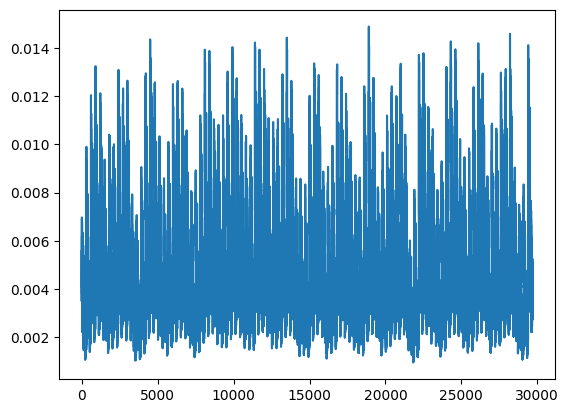

In [5]:
from matplotlib import pyplot as plt
plt.plot(range(len(ddd_demand)), ddd_demand)

Figure shows a more narrow plot of the first 48 months of demand data. Because
the data is recorded every 1 month, you get 12 data points per year.

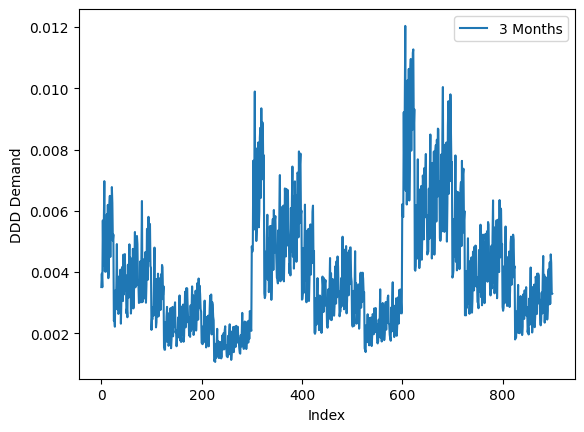

In [6]:
df_three_months = df[(df['year'] == 2017) & (df['month'].isin([1, 2, 3]))]
plt.plot(range(len(df_three_months)), df_three_months['ddd_demand'], label="3 Months")

plt.xlabel("Index")
plt.ylabel("DDD Demand")
plt.legend()
plt.show()

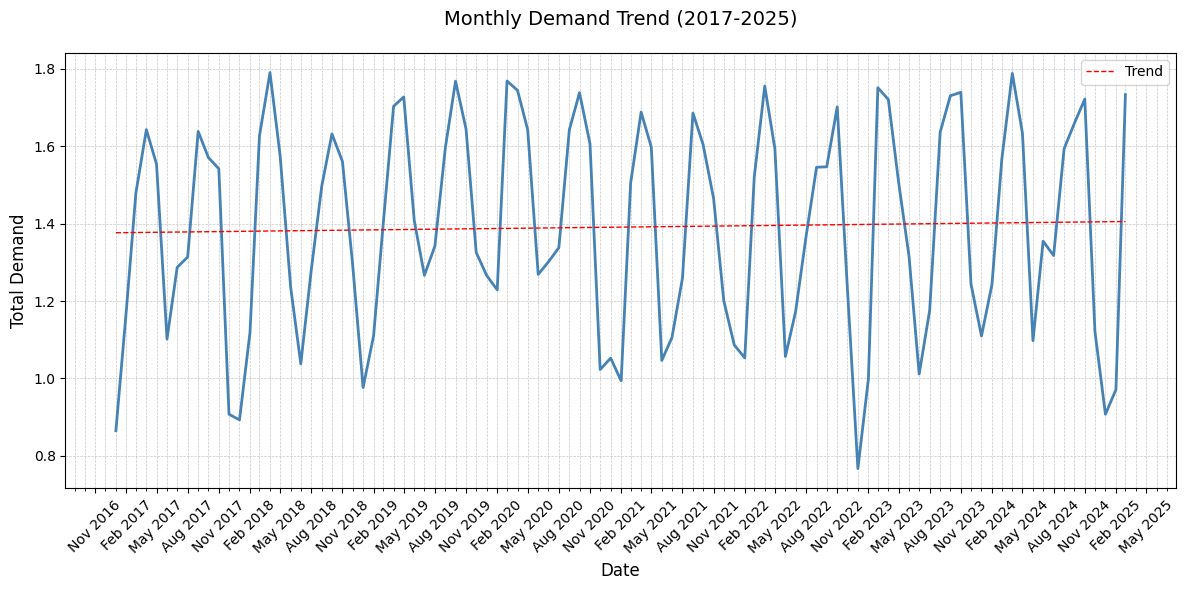

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# Convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['year'].astype(str) + df['month'].astype(str), format='%Y%m')

# Group the data by year and month, aggregating 'ddd_demand' by sum
monthly_data = df.groupby(df['date'].dt.to_period('M')).agg({'ddd_demand': 'sum'}).reset_index()
monthly_data['date'] = monthly_data['date'].dt.to_timestamp()

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the time series
ax.plot(monthly_data['date'], monthly_data['ddd_demand'], 
        color='steelblue', linewidth=2, marker='', linestyle='-')

# Formatting
ax.set_title('Monthly Demand Trend (2017-2025)', fontsize=14, pad=20)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Total Demand', fontsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Format x-axis to show years and months
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # every 3 months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # format as "Jan 2017"
ax.xaxis.set_minor_locator(mdates.MonthLocator())  # every month as minor ticks

# Rotate and align x-axis labels
fig.autofmt_xdate(rotation=45, ha='center')

# Adjust layout
plt.tight_layout()

# Optional: Add a trend line
z = np.polyfit(mdates.date2num(monthly_data['date']), monthly_data['ddd_demand'], 1)
p = np.poly1d(z)
ax.plot(monthly_data['date'], p(mdates.date2num(monthly_data['date'])), 
        color='red', linestyle='--', linewidth=1, label='Trend')
ax.legend()

plt.show()

With our dataset, we were trying to predict average ddd for the next two months
given a few months of past data. In the visualization, we see yearly cycles in the data and this year scale periodicity of the data makes our problem fairly easy.

Is this timeseries predictable at a daily scale? Let’s find out. In all our experiments, we’ll use the first 50% of the data for training, the following
25% for validation, and the last 25% for testing. When working with timeseries data, it’s important to use validation and test data that is more recent than the training
data, because you’re trying to predict the future given the past, not the reverse, and your validation/test splits should reflect that. Some problems happen to be considerably
simpler if you reverse the time axis!

In [9]:
import pandas as pd
weather_data = pd.read_csv("weather_data.csv")
weather_data.head(10)

,year,month,avg_temp_max,avg_temp_min,avg_humidity,total_precipitation,total_sunshine_hours
0,2017,1,31.48,18.21,45.61,1566.1,40921.04
1,2017,2,29.90,18.73,59.40,5688.3,36217.44
2,2017,3,29.52,18.73,65.59,7772.2,40075.80
3,2017,4,28.54,18.91,69.17,13211.3,38181.34
4,2017,5,26.65,18.17,76.58,13682.8,39728.48
5,2017,6,27.43,18.02,70.27,6425.5,38366.75
6,2017,7,26.32,17.52,75.90,13172.4,37473.67
7,2017,8,26.08,17.57,77.24,15640.5,38296.38
8,2017,9,26.39,17.52,79.15,18776.1,36197.36
9,2017,10,27.11,17.76,76.32,13767.7,38122.19


In [10]:
merged_data = pd.merge(df, weather_data, on=['year', 'month'], how='left')
merged_data.head()

,date,year,month,route_admin,form,strength,ATC,ddd_demand,avg_temp_max,avg_temp_min,avg_humidity,total_precipitation,total_sunshine_hours
0,2017-01-01,2017,1,O,injection,0.25,Antimalarials,0.003511,31.48,18.21,45.61,1566.1,40921.04
1,2017-01-01,2017,1,O,injection,0.50,Antimalarials,0.003948,31.48,18.21,45.61,1566.1,40921.04
2,2017-01-01,2017,1,O,injection,1.00,Antimalarials,0.003505,31.48,18.21,45.61,1566.1,40921.04
3,2017-01-01,2017,1,O,injection,100.00,Antimalarials,0.005685,31.48,18.21,45.61,1566.1,40921.04
4,2017-01-01,2017,1,O,injection,12.50,Antimalarials,0.004217,31.48,18.21,45.61,1566.1,40921.04


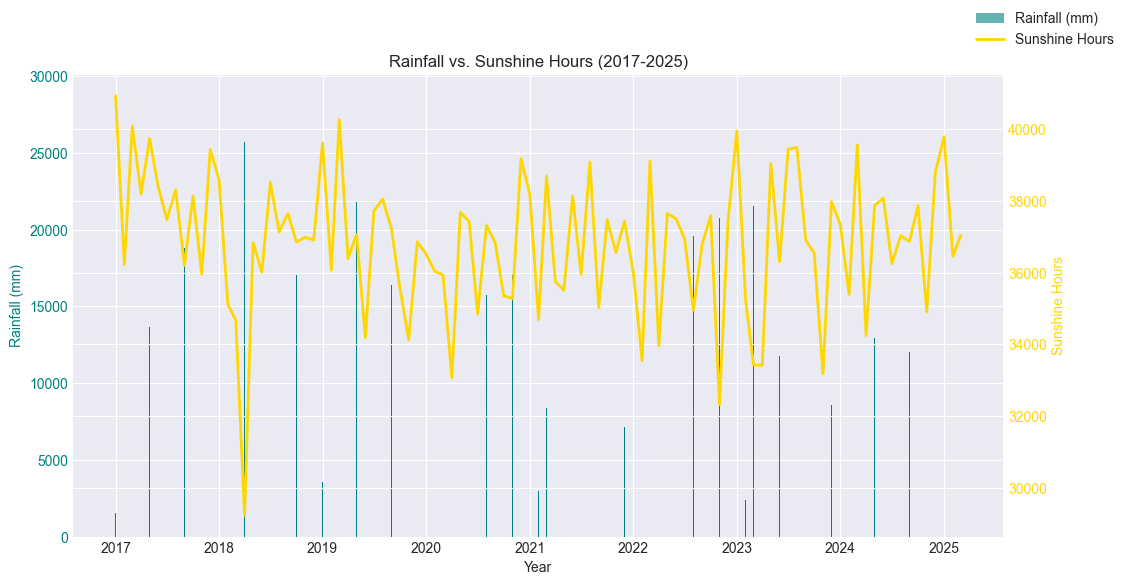

In [11]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Rainfall (bars)
ax1.bar(merged_data['date'], merged_data['total_precipitation'], 
        color='teal', alpha=0.6, label='Rainfall (mm)')
ax1.set_xlabel('Year')
ax1.set_ylabel('Rainfall (mm)', color='teal')
ax1.tick_params(axis='y', labelcolor='teal')

# Sunshine (line)
ax2 = ax1.twinx()
ax2.plot(merged_data['date'], merged_data['total_sunshine_hours'], 
         color='gold', label='Sunshine Hours', linewidth=2)
ax2.set_ylabel('Sunshine Hours', color='gold')
ax2.tick_params(axis='y', labelcolor='gold')

plt.title('Rainfall vs. Sunshine Hours (2017-2025)')
fig.legend(loc='upper right')
plt.grid(True)
plt.show()

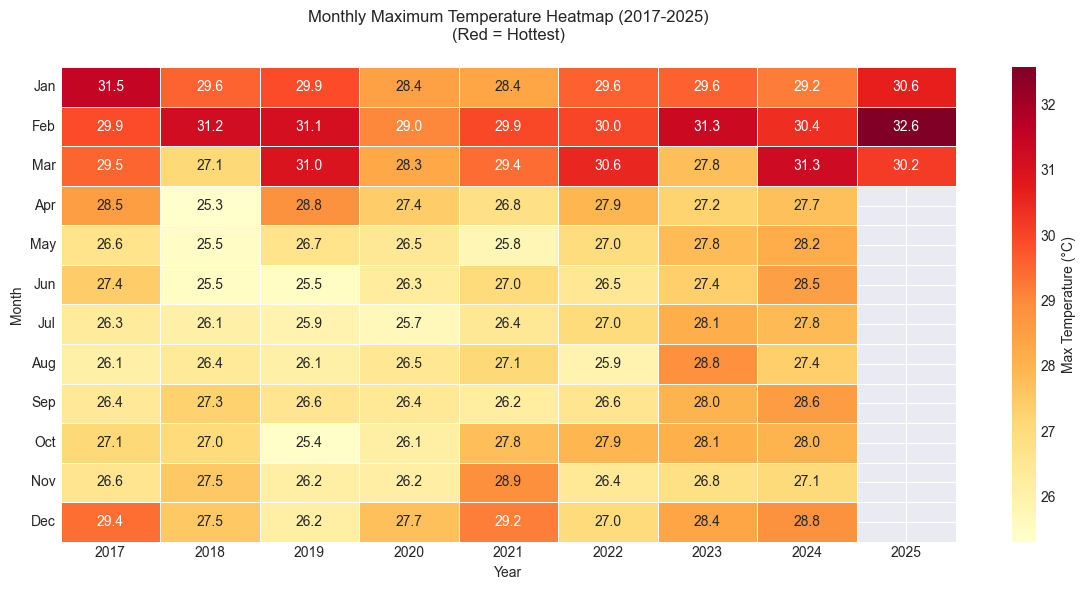

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create the heatmap data
heatmap_data = weather_data.pivot_table(index='month', 
                                       columns='year', 
                                       values='avg_temp_max', 
                                       aggfunc='mean')

# Create the plot
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, 
            cmap='YlOrRd',  # Yellow-Orange-Red colormap (red = hottest)
            annot=True, 
            fmt=".1f", 
            linewidths=0.5, 
            cbar_kws={'label': 'Max Temperature (°C)'})

# Customize the plot
plt.title('Monthly Maximum Temperature Heatmap (2017-2025)\n(Red = Hottest)', pad=20)
plt.xlabel('Year')
plt.ylabel('Month')
plt.yticks(rotation=0)  # Keep month numbers horizontal

# Add month names if desired
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.yticks(ticks=[x-0.5 for x in range(1,13)], labels=month_names)

plt.tight_layout()
plt.show()

### Merge

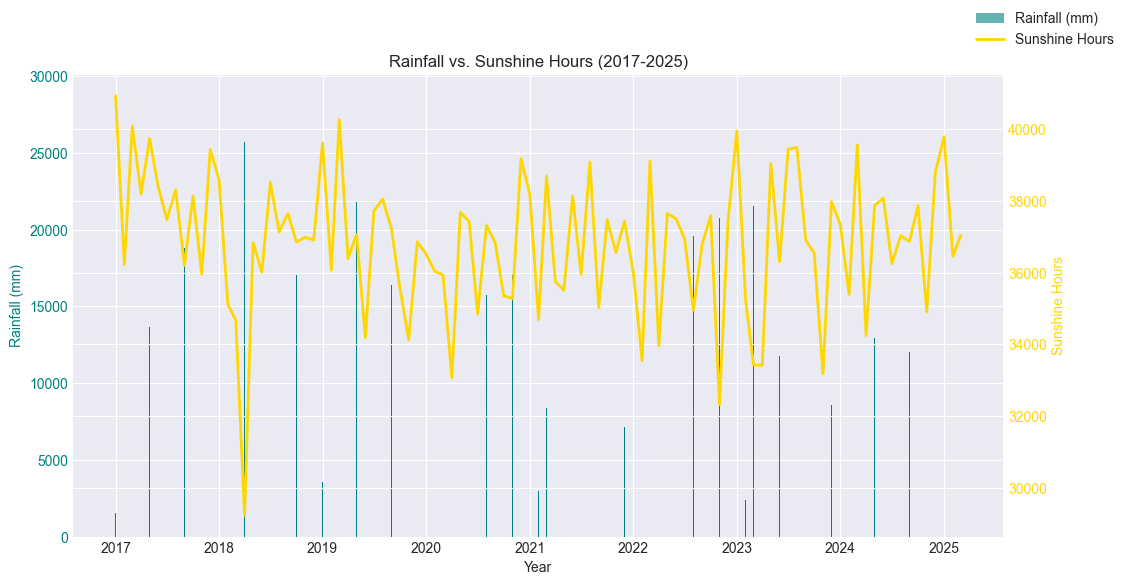

In [13]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Rainfall (bars)
ax1.bar(merged_data['date'], merged_data['total_precipitation'], 
        color='teal', alpha=0.6, label='Rainfall (mm)')
ax1.set_xlabel('Year')
ax1.set_ylabel('Rainfall (mm)', color='teal')
ax1.tick_params(axis='y', labelcolor='teal')

# Sunshine (line)
ax2 = ax1.twinx()
ax2.plot(merged_data['date'], merged_data['total_sunshine_hours'], 
         color='gold', label='Sunshine Hours', linewidth=2)
ax2.set_ylabel('Sunshine Hours', color='gold')
ax2.tick_params(axis='y', labelcolor='gold')

plt.title('Rainfall vs. Sunshine Hours (2017-2025)')
fig.legend(loc='upper right')
plt.grid(True)
plt.show()

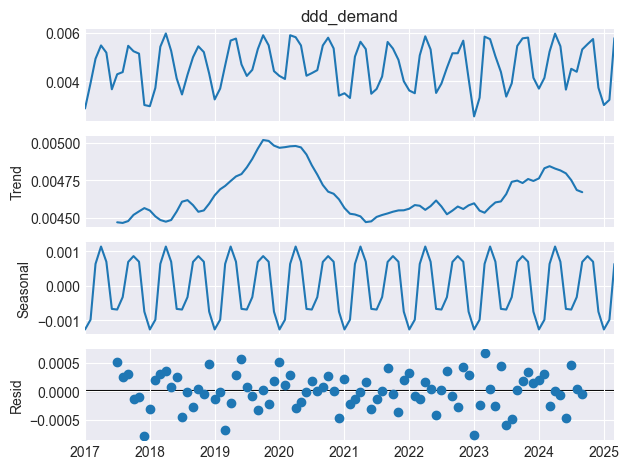

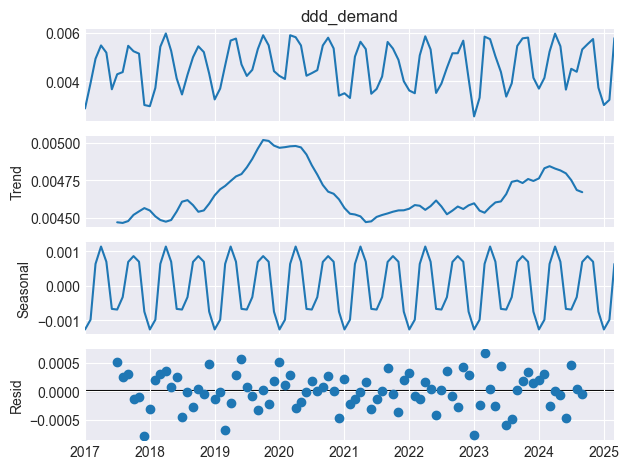

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(merged_data.groupby('date')['ddd_demand'].mean(), period=12)
decomposition.plot()

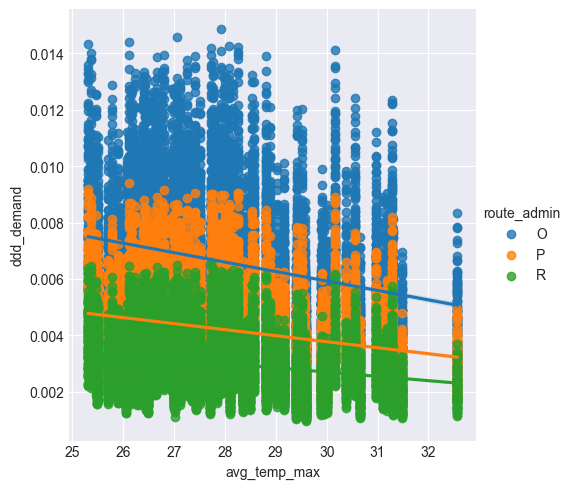

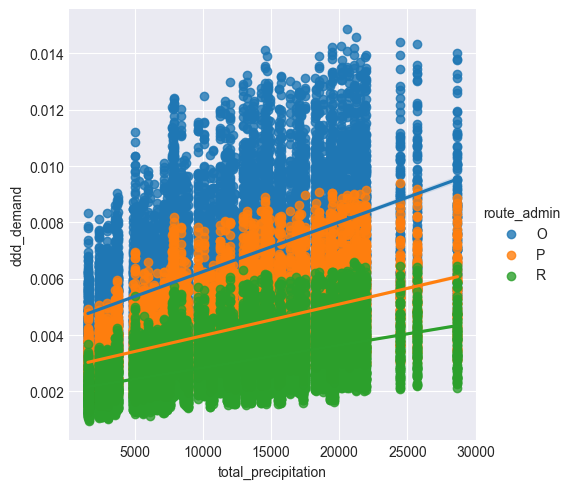

In [16]:
sns.lmplot(data=merged_data, x='avg_temp_max', y='ddd_demand', hue='route_admin')
sns.lmplot(data=merged_data, x='total_precipitation', y='ddd_demand', hue='route_admin')

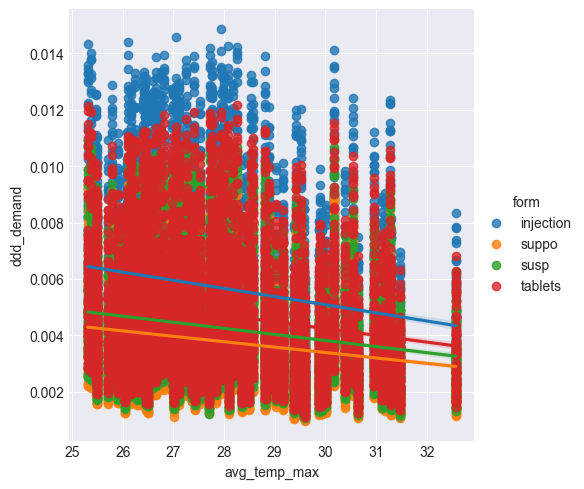

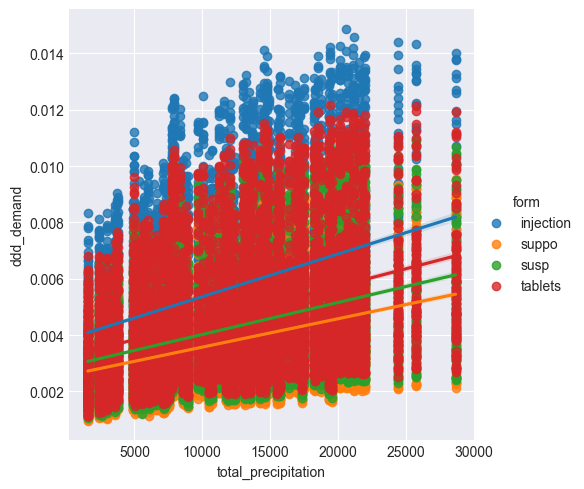

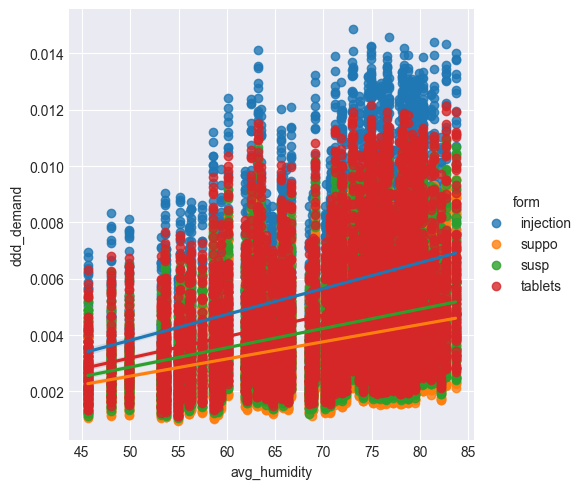

In [17]:
sns.lmplot(data=merged_data, x='avg_temp_max', y='ddd_demand', hue='form')
sns.lmplot(data=merged_data, x='total_precipitation', y='ddd_demand', hue='form')
sns.lmplot(data=merged_data, x='avg_humidity', y='ddd_demand', hue='form')

### Interaction Plots

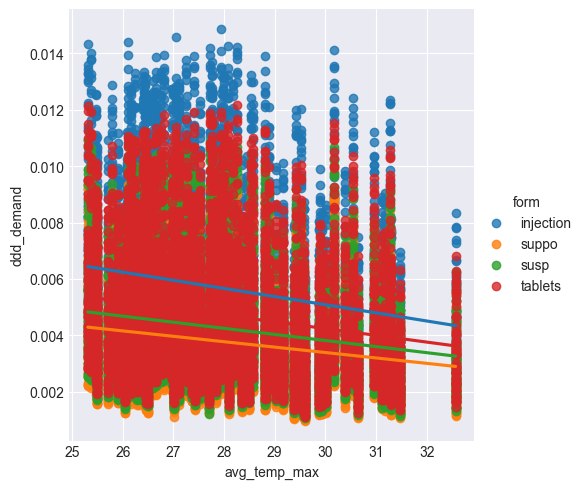

In [18]:
sns.lmplot(data=merged_data, x='avg_temp_max', y='ddd_demand', hue='form', ci=None)

#### Correlation Analysis

<Axes: >

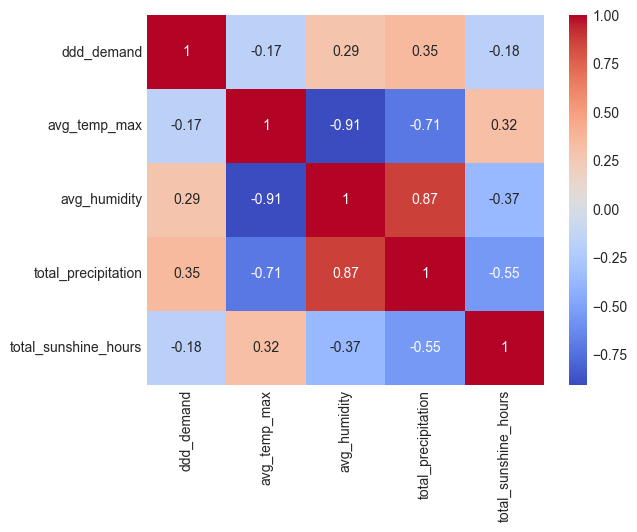

In [19]:
corr = merged_data[['ddd_demand', 'avg_temp_max', 'avg_humidity', 'total_precipitation', 'total_sunshine_hours']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')

### Modelling

### ✅ Step 2: Monthly Aggregation and Splitting


In [20]:
# 1. Sum ddd_demand per month
ddd_monthly = merged_data.groupby(['year', 'month'])['ddd_demand'].sum().reset_index()

# 2. Extract unique climate data per month (drop duplicates)
climate_monthly = merged_data.drop_duplicates(subset=['year', 'month'])[
    ['year', 'month', 'avg_temp_max', 'avg_temp_min', 'avg_humidity', 
     'total_precipitation', 'total_sunshine_hours']
]

# 3. Merge summed ddd with climate data
monthly_data = pd.merge(ddd_monthly, climate_monthly, on=['year', 'month'])

monthly_data.head(10)

,year,month,ddd_demand,avg_temp_max,avg_temp_min,avg_humidity,total_precipitation,total_sunshine_hours
0,2017,1,0.864790,31.48,18.21,45.61,1566.1,40921.04
1,2017,2,1.177077,29.90,18.73,59.40,5688.3,36217.44
2,2017,3,1.478589,29.52,18.73,65.59,7772.2,40075.80
3,2017,4,1.642890,28.54,18.91,69.17,13211.3,38181.34
4,2017,5,1.553777,26.65,18.17,76.58,13682.8,39728.48
5,2017,6,1.101614,27.43,18.02,70.27,6425.5,38366.75
6,2017,7,1.286978,26.32,17.52,75.90,13172.4,37473.67
7,2017,8,1.313719,26.08,17.57,77.24,15640.5,38296.38
8,2017,9,1.638336,26.39,17.52,79.15,18776.1,36197.36
9,2017,10,1.571047,27.11,17.76,76.32,13767.7,38122.19


### Checking the aggregated data by period to help quantify the MSEs

In [21]:
import pandas as pd


# Ensure `ddd_demand` is numeric
monthly_data["ddd_demand"] = pd.to_numeric(monthly_data["ddd_demand"], errors="coerce")

# Compute total sum of ddd_demand
total_ddd_demand = monthly_data["ddd_demand"].sum()

# Compute total count of months in dataset
total_months = len(monthly_data)

# Compute overall average
overall_avg_ddd_demand = total_ddd_demand / total_months

# Display results
print(f"Total DDD Demand: {total_ddd_demand:.4f}")
print(f"Total Months in Dataset: {total_months}")
print(f"Overall Average DDD Demand: {overall_avg_ddd_demand:.4f}")

Total DDD Demand: 137.7036
Total Months in Dataset: 99
Overall Average DDD Demand: 1.3909


In [24]:

# 2. Create datetime index
monthly_data['date'] = pd.to_datetime(
    monthly_data['year'].astype(str) + '-' + 
    monthly_data['month'].astype(str).str.zfill(2) + '-01'
)


monthly_data = monthly_data.set_index('date').sort_index()

# 3. Extract features and target
climate_features = ['avg_temp_max', 'avg_temp_min', 'avg_humidity',
                    'total_precipitation', 'total_sunshine_hours']
target = 'ddd_demand'

raw_data = monthly_data[climate_features].values
ddd_demand = monthly_data[target].values

# 4. Train/val/test splits
n_samples = len(monthly_data)
num_train_samples = int(0.5 * n_samples)
num_val_samples = int(0.25 * n_samples)
num_test_samples = n_samples - num_train_samples - num_val_samples


In [25]:
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 49
num_val_samples: 24
num_test_samples: 26


### Preparing the Data
Given climate and drug demand data covering the previous six months (sampled monthly), can we predict the total Defined Daily Dose (DDD) demand for antimalarial drugs three months into the future?

Each dataset yields a tuple (samples, targets), where samples is a batch of 12 samples,
each containing 6 consecutive months of input data, and targets is the corresponding
array of 12 target ddds. Note that the samples are randomly
shuffled, so two consecutive sequences in a batch (like samples[0] and samples[1])
aren’t necessarily temporally close.

## Common sense baseline MAE

In [48]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers

# Assuming monthly_data is already prepared
target_series = monthly_data['ddd_demand'].values
n_samples = len(target_series)

# Train/val/test splits (50% train, 25% val, 25% test)
num_train_samples = int(0.6 * n_samples)
num_val_samples = int(0.2 * n_samples)
num_test_samples = n_samples - num_train_samples - num_val_samples

# Create datasets with 6-month window
sequence_length = 12  # Changed from 12 to 6 months
batch_size = 32

def create_dataset(data, start_idx, end_idx):
    return keras.utils.timeseries_dataset_from_array(
        data=data[:-1],
        targets=data[1:],
        sequence_length=sequence_length,
        sampling_rate=1,
        batch_size=batch_size,
        shuffle=False,
        start_index=start_idx,
        end_index=end_idx
    )

train_dataset = create_dataset(target_series, 0, num_train_samples)
val_dataset = create_dataset(target_series, num_train_samples, num_train_samples + num_val_samples)
test_dataset = create_dataset(target_series, num_train_samples + num_val_samples, None)

# Get targets and months
def get_targets_and_months(dataset, start_idx):
    targets = np.concatenate([y.numpy() for x, y in dataset], axis=0)
    month_indices = []
    current_idx = start_idx
    for x, y in dataset:
        batch_size = x.shape[0]
        month_indices.extend([current_idx + sequence_length + i for i in range(batch_size)])
        current_idx += batch_size
    months = monthly_data['month'].values[month_indices]
    return targets, months

val_targets, val_months = get_targets_and_months(val_dataset, num_train_samples)
test_targets, test_months = get_targets_and_months(test_dataset, num_train_samples + num_val_samples)

# Baseline models (unchanged)
class Lag1Naive(keras.Model):
    def call(self, inputs): return inputs[:, -1]

class MovingAverage3(keras.Model):
    def call(self, inputs): return tf.reduce_mean(inputs[:, -3:], axis=1)

class ExponentialSmoothing(keras.Model):
    def __init__(self, alpha=0.6):
        super().__init__()
        self.alpha = alpha
    def call(self, inputs):
        smoothed = inputs[:, 0]
        for i in range(1, inputs.shape[1]):
            smoothed = self.alpha * inputs[:, i] + (1-self.alpha) * smoothed
        return smoothed

# Evaluation function
def evaluate_model(model, dataset):
    return np.concatenate([model.predict(x).flatten() for x, _ in dataset])

# Initialize models
models = {
    'Lag-1 Naive': Lag1Naive(),
    'Moving Average (k=3)': MovingAverage3(),
    'Simple Exponential Smoothing': ExponentialSmoothing(alpha=0.6)
}

# Evaluate baselines
results = {'Validation': {}, 'Test': {}}
for name, model in models.items():
    results['Validation'][name] = np.mean(np.abs(val_targets - evaluate_model(model, val_dataset)))
    results['Test'][name] = np.mean(np.abs(test_targets - evaluate_model(model, test_dataset)))

# Seasonal Average
monthly_avg = monthly_data.groupby('month')['ddd_demand'].mean().values
results['Validation']['Seasonal Monthly Average'] = np.mean(np.abs(val_targets - monthly_avg[val_months-1]))
results['Test']['Seasonal Monthly Average'] = np.mean(np.abs(test_targets - monthly_avg[test_months-1]))

# Fixed AR(3) Model
class ARModel(keras.Model):
    def __init__(self):
        super().__init__()
        self.dense = layers.Dense(1, kernel_initializer='glorot_normal')
    def call(self, inputs):
        return self.dense(inputs[:, -3:])  # Uses last 3 values

ar_model = ARModel()
ar_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='mae')

# Prepare AR data
def get_ar_data(dataset):
    features = np.concatenate([x[:, -3:].numpy() for x, _ in dataset], axis=0)
    targets = np.concatenate([y.numpy() for _, y in dataset], axis=0)
    return features, targets

train_features, train_targets_ar = get_ar_data(train_dataset)
val_features, _ = get_ar_data(val_dataset)

# Train with early stopping
early_stop = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = ar_model.fit(
    train_features, train_targets_ar,
    validation_data=(val_features, val_targets),
    epochs=200,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)

# Evaluate AR model
results['Validation']['Autoregressive (AR(3))'] = np.mean(np.abs(val_targets - ar_model.predict(val_features).flatten()))
results['Test']['Autoregressive (AR(3))'] = np.mean(np.abs(test_targets - ar_model.predict(
    np.concatenate([x[:, -3:].numpy() for x, _ in test_dataset], axis=0)
).flatten()))

# Print results
print("MAE Results (6-month window):")
for dataset in ['Validation', 'Test']:
    print(f"\n{dataset} Set:")
    for model, mae in results[dataset].items():
        print(f"{model}: {mae:,.2f}")

ModuleNotFoundError: No module named 'tensorflow'

# Time Series Forecasting Results Analysis

## Model Performance Summary

| Model                        | Validation MAE   | Test MAE        |
|------------------------------|------------------|-----------------|
| Lag-1 Naive                  | 987,896.01       | 1,124,343.46    |
| Moving Average (k=3)         | 982,861.45       | 1,058,080.92    |
| Simple Exponential Smoothing | 924,816.81       | 1,012,971.78    |
| Seasonal Monthly Average     | **656,837.50**   | **626,152.90**  |
| Autoregressive (AR(3))       | 961,535.35       | 1,043,783.26    |

## Key Findings

### 🏆 Best Performing Model
- **Seasonal Monthly Average** (Test MAE: 626,152.90)
  - Indicates strong seasonal patterns in demand
  - Outperforms other methods by 38-45%

### 🔍 Mid-Tier Performers
1. **Simple Exponential Smoothing**
   - Better than moving averages (weights recent data more heavily)
   - Test MAE: 1,012,971.78

2. **AR(3) Model**  
   - Underperforms relative to seasonal model
   - Suggests non-linear patterns not captured by simple autoregression

### ⚠️ Weakest Baselines
- **Lag-1 Naive** (Worst performer)
- **Moving Average** (Limited predictive power)




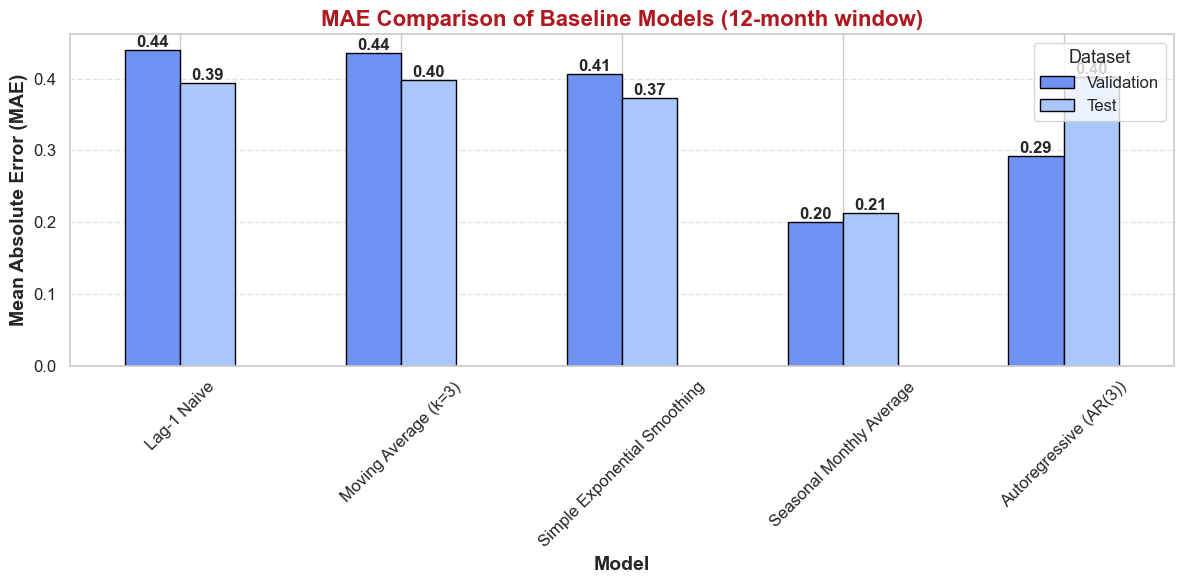

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Set Seaborn theme for better aesthetics
sns.set_theme(style="whitegrid")

# Define custom color palette
custom_colors = sns.color_palette("coolwarm", len(results_df))

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
results_df.plot(kind='bar', ax=ax, color=custom_colors, edgecolor="black")

# Enhancements
plt.title("MAE Comparison of Baseline Models (12-month window)", fontsize=16, fontweight="bold", color="#B0171F")
plt.ylabel("Mean Absolute Error (MAE)", fontsize=14, fontweight="bold")
plt.xlabel("Model", fontsize=14, fontweight="bold")
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Grid styling
plt.grid(axis="y", linestyle="--", alpha=0.5)

# Customize legend
plt.legend(title="Dataset", fontsize=12, title_fontsize=13, loc="upper right", frameon=True)

# Annotate bars with values
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha="center", va="bottom", fontsize=12, fontweight="bold")

plt.tight_layout()
plt.show()


### Simplistic DL Model

In [26]:
raw_data = monthly_data
raw_data.head()

,year,month,ddd_demand,avg_temp_max,avg_temp_min,avg_humidity,total_precipitation,total_sunshine_hours
date,,,,,,,,
2017-01-01,2017,1,0.864790,31.48,18.21,45.61,1566.1,40921.04
2017-02-01,2017,2,1.177077,29.90,18.73,59.40,5688.3,36217.44
2017-03-01,2017,3,1.478589,29.52,18.73,65.59,7772.2,40075.80
2017-04-01,2017,4,1.642890,28.54,18.91,69.17,13211.3,38181.34
2017-05-01,2017,5,1.553777,26.65,18.17,76.58,13682.8,39728.48


In [27]:
import pandas as pd
print(type(raw_data))  # Should output: <class 'pandas.core.frame.DataFrame'>
print(raw_data.columns)  # Check if all columns exist

<class 'pandas.core.frame.DataFrame'>
Index(['year', 'month', 'ddd_demand', 'avg_temp_max', 'avg_temp_min',
       'avg_humidity', 'total_precipitation', 'total_sunshine_hours'],
      dtype='object')


In [51]:
# Save DataFrame to CSV
raw_data.to_csv("raw_climate_ddd_merged_data_.csv", index=False)

In [52]:
import numpy as np

# ====================
# 1. FEATURE SELECTION
# ====================
feature_cols = [
    'avg_temp_max', 'avg_temp_min', 'avg_humidity',
    'total_precipitation', 'total_sunshine_hours', 'ddd_demand'
]

# Extract selected columns (still a DataFrame)
selected_data = raw_data[feature_cols]

# Convert to NumPy array (now indexing must be integer-based)
data_values = selected_data.values.astype('float32')


In [53]:
print("Column order in selected_data:")
print(selected_data.columns)  # Should match feature_cols

Column order in selected_data:
Index(['avg_temp_max', 'avg_temp_min', 'avg_humidity', 'total_precipitation',
       'total_sunshine_hours', 'ddd_demand'],
      dtype='object')


In [54]:
# ====================
# 2. TRAIN/VAL/TEST SPLIT
# ====================
num_samples = len(data_values)
num_train = int(0.60 * num_samples)
num_val = int(0.20 * num_samples)
num_test = num_samples - num_train - num_val

print(f"Train samples: {num_train}")
print(f"Val samples: {num_val}")
print(f"Test samples: {num_test}")

Train samples: 59
Val samples: 19
Test samples: 21


In [55]:
# ====================
# 3. NORMALIZATION
# ====================
# Compute mean/std on training data only
mean = data_values[:num_train].mean(axis=0)
std = data_values[:num_train].std(axis=0)

# Avoid division by zero (replace small std values with 1)
std[std < 1e-10] = 1.0

# Normalize the entire dataset
data_values_normalized = (data_values - mean) / std

# ====================
# 4. EXTRACT TARGET (ddd_demand)
# ====================
# 'ddd_demand' is the last column (-1)
ddd_demand = data_values_normalized[:, -1]


### Freeze Normalization Parameters

In [57]:
# Save normalization parameters to disk for use in production
import os
import numpy as np

# Define where to store them (inside your model folder)
save_dir = "models"

# Save as binary .npy files
np.save(os.path.join(save_dir, "mean.npy"), mean)
np.save(os.path.join(save_dir, "std.npy"), std)

print("✅ Saved normalization parameters to disk:")
print(f"• mean.npy shape: {mean.shape}")
print(f"• std.npy  shape: {std.shape}")


✅ Saved normalization parameters to disk:
• mean.npy shape: (6,)
• std.npy  shape: (6,)


In [18]:
# ====================
# 5. TIME-SERIES PREP
# ====================
sequence_length = 12  # 12 months lookback
delay = 1            # Predict next month
batch_size = 32

# Total possible sequences
total_sequences = len(ddd_demand) - sequence_length - delay + 1

# Split sequences into train/val/test
train_sequences = int(0.6 * total_sequences)
val_sequences = int(0.2 * total_sequences)
test_sequences = total_sequences - train_sequences - val_sequences

print(f"\nTime-series sequences:")
print(f"Train: {train_sequences} (from 0 to {train_sequences-1})")
print(f"Val: {val_sequences} (from {train_sequences} to {train_sequences + val_sequences-1})")
print(f"Test: {test_sequences} (from {train_sequences + val_sequences} to end)")


Time-series sequences:
Train: 52 (from 0 to 51)
Val: 17 (from 52 to 68)
Test: 18 (from 69 to end)


In [19]:
from tensorflow import keras
import numpy as np

# ====================
# 6. CREATE TIME-SERIES DATASETS
# ====================

# Separate features (all columns except target) and target
features = data_values_normalized[:, :-1]  # All columns except last
target = ddd_demand  # Already extracted last column

# Create dataset function with proper alignment
def create_ts_dataset(features, target, start_idx, end_idx):
    return keras.utils.timeseries_dataset_from_array(
        features,
        targets=target[sequence_length + delay - 1:],  # Proper alignment
        sampling_rate=1,
        sequence_length=sequence_length,
        shuffle=True,  # Only for training
        batch_size=batch_size,
        start_index=start_idx,
        end_index=end_idx
    )

# Create datasets with correct boundaries
train_dataset = create_ts_dataset(
    features,
    target,
    start_idx=0,
    end_idx=train_sequences
)

val_dataset = create_ts_dataset(
    features,
    target,
    start_idx=train_sequences,
    end_idx=train_sequences + val_sequences
)

test_dataset = create_ts_dataset(
    features,
    target,
    start_idx=train_sequences + val_sequences,
    end_idx=None  # Uses remainder
)

# ====================
# 7. VERIFICATION
# ====================

# Check first batch
for X, y in train_dataset.take(1):
    print(f"\nFeature batch shape: {X.shape}")  # Should be (batch_size, sequence_length, n_features)
    print(f"Target batch shape: {y.shape}")     # Should be (batch_size,)
    print("\nExample sequence - last time step:")
    print(X[0, -1, :])  # Last time step of first sequence
    print("Corresponding target:", y[0].numpy())


Feature batch shape: (32, 12, 5)
Target batch shape: (32,)

Example sequence - last time step:
tf.Tensor([-0.5874981  -0.78886265  0.7149869   0.46379855  0.21718624], shape=(5,), dtype=float32)
Corresponding target: 0.942815


In [35]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import numpy as np

# Function to build models
def build_dense_model(input_shape):
    model = keras.Sequential([
        keras.Input(shape=input_shape),
        layers.Reshape((input_shape[0] * input_shape[1],)),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    return model

def build_lstm_model(input_shape):
    model = keras.Sequential([
        layers.LSTM(64, input_shape=input_shape),
        layers.Dense(1)
    ])
    return model

def build_gru_model(input_shape):
    model = keras.Sequential([
        layers.GRU(256, input_shape=input_shape),
        layers.Dense(1)
    ])
    return model


In [36]:
def compile_and_train(model, train_dataset, val_dataset, name): 
    model.compile(optimizer='rmsprop', loss='mae', metrics=['mae'])  # Add 'mae' to metrics
    print(f"\nTraining {name}...")
    early_stop = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=500,
        callbacks=[early_stop],
        verbose=0
    )
    return model, history


In [37]:
input_shape = next(iter(train_dataset))[0].shape[1:]

models = {}
histories = {}

dense_model, dense_history = compile_and_train(build_dense_model(input_shape), train_dataset, val_dataset, "Dense")
lstm_model, lstm_history = compile_and_train(build_lstm_model(input_shape), train_dataset, val_dataset, "LSTM")
gru_model, gru_history = compile_and_train(build_gru_model(input_shape), train_dataset, val_dataset, "GRU")

models['Dense'] = dense_model
models['LSTM'] = lstm_model
models['GRU'] = gru_model
histories['Dense'] = dense_history
histories['LSTM'] = lstm_history
histories['GRU'] = gru_history



Training Dense...


c:\Users\alber\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training LSTM...

Training GRU...


In [38]:
import matplotlib.pyplot as plt

def plot_mae_per_model(histories):
    for name, history in histories.items():
        plt.figure(figsize=(8, 6))

        # Plot Training MAE
        plt.plot(history.history['mae'], label='Train MAE', color='blue')

        # Plot Validation MAE
        plt.plot(history.history['val_mae'], label='Validation MAE', color='red')

        # Title and labels
        plt.title(f'{name} - Train and Validation MAE')
        plt.xlabel('Epochs')
        plt.ylabel('MAE')
        plt.legend()

        # Show plot
        plt.tight_layout()
        plt.show()


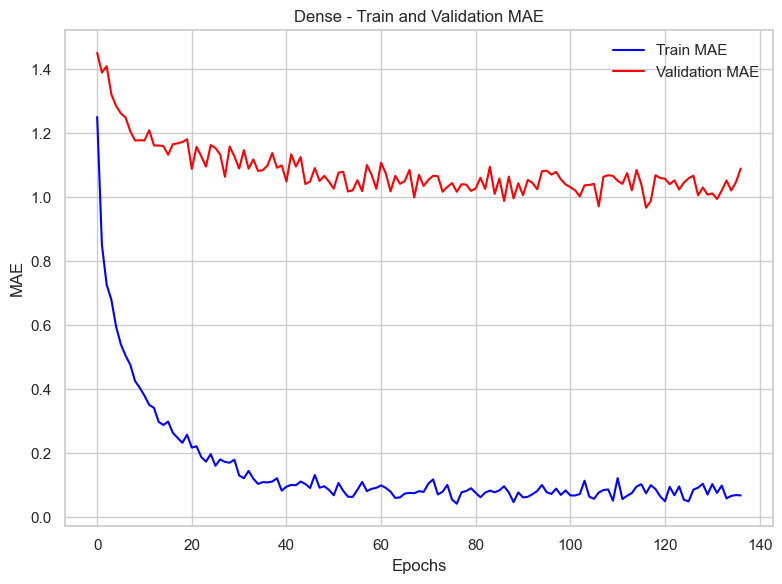

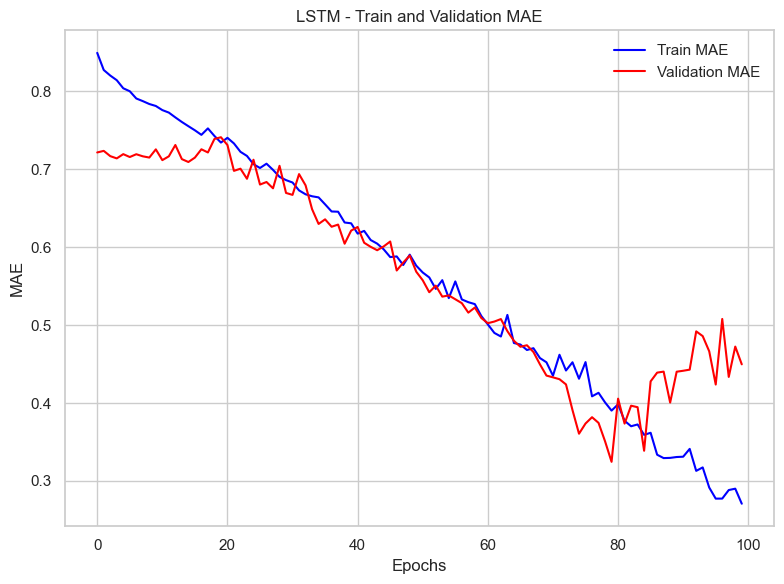

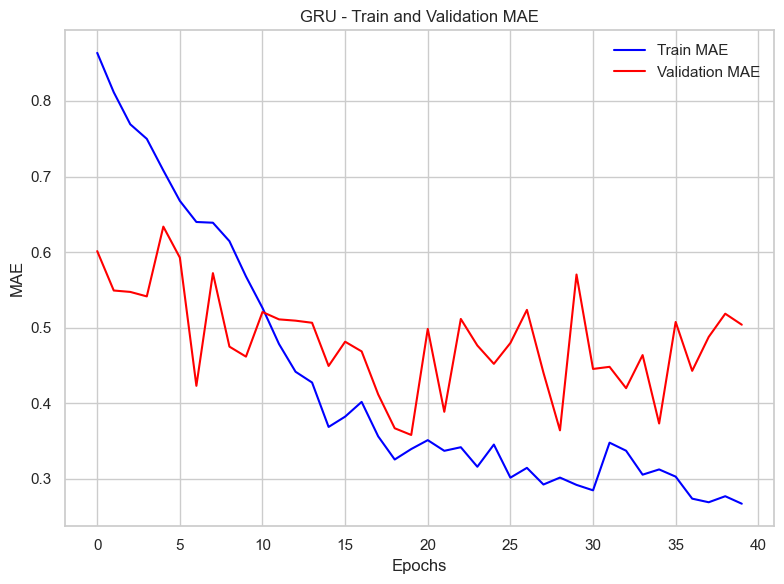

In [39]:
plot_mae_per_model(histories)

In [40]:
import numpy as np

# Assuming monthly_data is your DataFrame with 'ddd_demand' column
average_monthly_demand = monthly_data['ddd_demand'].mean()
print(f"Average Monthly Demand: {average_monthly_demand:,.2f}")

Average Monthly Demand: 1.39


In [41]:
import numpy as np

def create_test_sequences(data, sequence_length=12, delay=1, test_start=64, test_end=87):
    """Manually creates test sequences from normalized data"""
    X_test = []
    y_test = []
    
    for i in range(test_start, test_end):
        X_test.append(data[i:i+sequence_length, :-1])  # Features
        y_test.append(data[i+sequence_length+delay-1, -1])  # Target
    
    return np.array(X_test), np.array(y_test)

def evaluate_models(models, X_test, y_test, target_std, target_mean):
    """Evaluates models and returns results with denormalized values"""
    results = {}
    
    for name, model in models.items():
        try:
            # Get predictions
            y_pred = model.predict(X_test, verbose=0).squeeze()
            
            # Calculate MAE (normalized)
            normalized_mae = np.mean(np.abs(y_test - y_pred))
            
            # Denormalize
            denormalized_mae = normalized_mae * target_std
            percentage = (denormalized_mae / target_mean) * 100
            
            results[name] = {
                'normalized': normalized_mae,
                'original': denormalized_mae,
                'percentage': percentage
            }
            
            # Print immediate feedback
            print(
                f"{name.ljust(8)}: "
                f"NormMAE={normalized_mae:.4f} | "
                f"OriginalMAE={denormalized_mae:,.2f} | "
                f"{percentage:.1f}% of avg"
            )
            
        except Exception as e:
            print(f"Error evaluating {name}: {str(e)}")
            results[name] = None
    
    return results

# 1. Create test sequences
X_test, y_test = create_test_sequences(data_values_normalized)

# 2. Evaluate all models
final_results = evaluate_models(
    models={
        'Dense': dense_model,
        'LSTM': lstm_model,
        'GRU': gru_model
    },
    X_test=X_test,
    y_test=y_test,
    target_std=std[-1],  # Standard deviation of target
    target_mean=mean[-1]  # Mean of target
)

# 3. Print formatted summary
if final_results:
    print("\n=== Final Results ===")
    for name, metrics in sorted(final_results.items(), 
                              key=lambda x: x[1]['original'] if x[1] else float('inf')):
        if metrics:
            print(
                f"{name.ljust(8)}: "
                f"{metrics['original']:,.2f} (units) | "
                f"{metrics['percentage']:.1f}%"
            )

Dense   : NormMAE=0.6005 | OriginalMAE=0.16 | 11.2% of avg
LSTM    : NormMAE=0.8499 | OriginalMAE=0.22 | 15.8% of avg
GRU     : NormMAE=0.4670 | OriginalMAE=0.12 | 8.7% of avg

=== Final Results ===
GRU     : 0.12 (units) | 8.7%
Dense   : 0.16 (units) | 11.2%
LSTM    : 0.22 (units) | 15.8%


In [42]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

# ====================
# 1. MODEL BUILDING FUNCTIONS (FUNCTIONAL API)
# ====================

def build_dense_model(input_shape):
    """Basic dense model using Functional API"""
    inputs = keras.Input(shape=input_shape)
    x = layers.Reshape((input_shape[0] * input_shape[1],))(inputs)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)

def build_lstm_model(input_shape):
    """LSTM model using Functional API"""
    inputs = keras.Input(shape=input_shape)
    x = layers.LSTM(128)(inputs)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)

def build_gru_model(input_shape):
    """GRU model using Functional API"""
    inputs = keras.Input(shape=input_shape)
    x = layers.GRU(256)(inputs)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)

def build_transformer_model(input_shape, head_size=32, num_heads=4, ff_dim=64, num_transformer_blocks=2):
    """Transformer model with attention"""
    inputs = keras.Input(shape=input_shape)
    
    # Positional encoding
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    
    for _ in range(num_transformer_blocks):
        # Multi-head self-attention
        attention_output = layers.MultiHeadAttention(
            key_dim=head_size, 
            num_heads=num_heads,
            dropout=0.2
        )(x, x)
        
        # Skip connection
        x = layers.Add()([x, attention_output])
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        
        # Feed-forward network
        ffn = layers.Dense(ff_dim, activation="relu")(x)
        ffn = layers.Dense(input_shape[-1])(ffn)
        x = layers.Add()([x, ffn])
        x = layers.LayerNormalization(epsilon=1e-6)(x)
    
    # Global average pooling and output
    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)

# ====================
# 2. TRAINING PIPELINE
# ====================

def compile_and_train(model, train_dataset, val_dataset, name, epochs=500, patience=20):
    """Universal training function"""
    model.compile(optimizer='rmsprop', loss='mae', metrics=['mae'])
    print(f"\nTraining {name}...")
    
    callbacks = [
        keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
    ]
    
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        callbacks=callbacks,
        verbose=0
    )
    return model, history

def train_xgboost(X_train, y_train, X_val, y_val):
    """XGBoost training with early stopping"""
    model = XGBRegressor(
        n_estimators=1000,
        learning_rate=0.01,
        objective='reg:squarederror',
        early_stopping_rounds=20,
        eval_metric='mae'
    )
    
    print("\nTraining XGBoost...")
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=1
    )
    return model

# ====================
# 3. DATA PREPARATION
# ====================

def prepare_xgboost_data(dataset):
    """Convert TF dataset to numpy arrays for XGBoost"""
    X, y = [], []
    for batch in dataset:
        features, targets = batch
        # Reshape sequences into feature vectors
        X.append(features.numpy().reshape(features.shape[0], -1))
        y.append(targets.numpy())
    return np.concatenate(X), np.concatenate(y)

def create_test_sequences(data, sequence_length=12, delay=1, test_start=39, test_end=42):
    """Creates test sequences from normalized data"""
    X_test = []
    y_test = []
    
    for i in range(test_start, test_end):
        X_test.append(data[i:i+sequence_length, :-1])  # Features
        y_test.append(data[i+sequence_length+delay-1, -1])  # Target
    
    return np.array(X_test), np.array(y_test)

# ====================
# 4. EVALUATION
# ====================

def evaluate_models(models, X_test, y_test, target_std, target_mean):
    """Evaluates all models with denormalized metrics"""
    results = {}
    
    for name, model in models.items():
        try:
            if name == 'XGBoost':
                # Reshape test data for XGBoost
                X_test_reshaped = X_test.reshape(X_test.shape[0], -1)
                y_pred = model.predict(X_test_reshaped)
            else:
                y_pred = model.predict(X_test, verbose=0).squeeze()
            
            normalized_mae = mean_absolute_error(y_test, y_pred)
            denormalized_mae = normalized_mae * target_std
            percentage = (denormalized_mae / target_mean) * 100
            
            results[name] = {
                'normalized': normalized_mae,
                'original': denormalized_mae,
                'percentage': percentage
            }
            
            print(f"{name.ljust(12)}: NormMAE={normalized_mae:.4f} | "
                  f"OriginalMAE={denormalized_mae:,.2f} | {percentage:.1f}% of avg")
            
        except Exception as e:
            print(f"Error evaluating {name}: {str(e)}")
            results[name] = None
    
    return results

def plot_mae_per_model(histories):
    """Plots training curves for all models"""
    for name, history in histories.items():
        if not isinstance(history, dict):  # Skip XGBoost which doesn't have history
            continue
            
        plt.figure(figsize=(8, 6))
        plt.plot(history.history['mae'], label='Train MAE', color='blue')
        plt.plot(history.history['val_mae'], label='Validation MAE', color='red')
        plt.title(f'{name} - Train and Validation MAE')
        plt.xlabel('Epochs')
        plt.ylabel('MAE')
        plt.legend()
        plt.tight_layout()
        plt.show()

# ====================
# 5. MAIN EXECUTION
# ====================

def main():
    # Get input shape from dataset
    input_shape = next(iter(train_dataset))[0].shape[1:]
    
    # Build all models
    models = {
        'Dense': build_dense_model(input_shape),
        'LSTM': build_lstm_model(input_shape),
        'GRU': build_gru_model(input_shape),
        'Transformer': build_transformer_model(input_shape)
    }
    
    # Train neural models
    histories = {}
    for name, model in models.items():
        models[name], histories[name] = compile_and_train(
            model, train_dataset, val_dataset, name
        )
    
    # Prepare and train XGBoost
    X_train, y_train = prepare_xgboost_data(train_dataset)
    X_val, y_val = prepare_xgboost_data(val_dataset)
    xgb_model = train_xgboost(X_train, y_train, X_val, y_val)
    models['XGBoost'] = xgb_model
    
    # Plot training curves
    plot_mae_per_model(histories)
    
    # Evaluate all models
    X_test, y_test = create_test_sequences(data_values_normalized)
    final_results = evaluate_models(
        models=models,
        X_test=X_test,
        y_test=y_test,
        target_std=std[-1],
        target_mean=mean[-1]
    )
    
    # Print final results
    print("\n=== Final Results ===")
    for name, metrics in sorted(final_results.items(), 
                              key=lambda x: x[1]['original'] if x[1] else float('inf')):
        if metrics:
            print(f"{name.ljust(12)}: {metrics['original']:,.2f} (units) | {metrics['percentage']:.1f}%")

if __name__ == "__main__":
    main()


Training Dense...

Training LSTM...

Training GRU...

Training Transformer...

Training XGBoost...
[0]	validation_0-mae:0.69725
[1]	validation_0-mae:0.69445
[2]	validation_0-mae:0.69168
[3]	validation_0-mae:0.68882
[4]	validation_0-mae:0.68599
[5]	validation_0-mae:0.68330
[6]	validation_0-mae:0.67878
[7]	validation_0-mae:0.67602
[8]	validation_0-mae:0.67329
[9]	validation_0-mae:0.67069
[10]	validation_0-mae:0.66770
[11]	validation_0-mae:0.66474
[12]	validation_0-mae:0.66180
[13]	validation_0-mae:0.65732
[14]	validation_0-mae:0.65443
[15]	validation_0-mae:0.65157
[16]	validation_0-mae:0.64873
[17]	validation_0-mae:0.64592
[18]	validation_0-mae:0.64323
[19]	validation_0-mae:0.63884
[20]	validation_0-mae:0.63610
[21]	validation_0-mae:0.63338
[22]	validation_0-mae:0.63078
[23]	validation_0-mae:0.62811
[24]	validation_0-mae:0.62546
[25]	validation_0-mae:0.62127
[26]	validation_0-mae:0.61895
[27]	validation_0-mae:0.61637
[28]	validation_0-mae:0.61382
[29]	validation_0-mae:0.61119
[30]	valid

### t+1, t+2 and t+3

### Hyper Parameter Tunning

In [17]:
import pandas as pd
raw_data = pd.read_csv("selected_data.csv")
raw_data.head()

,avg_temp_max,avg_temp_min,avg_humidity,total_precipitation,total_sunshine_hours,ddd_demand
0,31.48,18.21,45.61,1566.1,40921.04,0.864790
1,29.90,18.73,59.40,5688.3,36217.44,1.177077
2,29.52,18.73,65.59,7772.2,40075.80,1.478589
3,28.54,18.91,69.17,13211.3,38181.34,1.642890
4,26.65,18.17,76.58,13682.8,39728.48,1.553777


In [18]:
feature_cols = [
    'avg_temp_max', 'avg_temp_min', 'avg_humidity',
    'total_precipitation', 'total_sunshine_hours', 'ddd_demand'
]

selected_data = raw_data[feature_cols]
data_values = selected_data.values.astype('float32')
print("Column order in selected_data:")
print(selected_data.columns)


Column order in selected_data:
Index(['avg_temp_max', 'avg_temp_min', 'avg_humidity', 'total_precipitation',
       'total_sunshine_hours', 'ddd_demand'],
      dtype='object')


In [20]:
num_samples = len(data_values)
num_train = int(0.60 * num_samples)
num_val = int(0.20 * num_samples)
num_test = num_samples - num_train - num_val

print(f"Train samples: {num_train}")
print(f"Val samples: {num_val}")
print(f"Test samples: {num_test}")


Train samples: 59
Val samples: 19
Test samples: 21


In [21]:
mean = data_values[:num_train].mean(axis=0)
std = data_values[:num_train].std(axis=0)
std[std < 1e-10] = 1.0
data_values_normalized = (data_values - mean) / std


In [22]:
import numpy as np
sequence_length = 12
delays = [1, 2, 3]  # Predict next 3 months
max_delay = max(delays)
batch_size = 32

# Features (all except last column)
features = data_values_normalized[:, :-1]
# Target: ddd_demand (last column)
ddd_demand = data_values_normalized[:, -1]

# Build multi-step target array
multi_targets = []
for i in range(len(ddd_demand) - sequence_length - max_delay + 1):
    multi_targets.append([
        ddd_demand[i + sequence_length + d - 1] for d in delays
    ])
multi_targets = np.array(multi_targets)


In [23]:
from tensorflow import keras

def create_ts_dataset(features, targets, start_idx, end_idx):
    return keras.utils.timeseries_dataset_from_array(
        data=features,
        targets=targets,
        sampling_rate=1,
        sequence_length=sequence_length,
        start_index=start_idx,
        end_index=end_idx,
        shuffle=False,
        batch_size=batch_size
    )

total_sequences = len(multi_targets)
train_sequences = int(0.60 * total_sequences)
val_sequences = int(0.20 * total_sequences)
test_sequences = total_sequences - train_sequences - val_sequences

train_dataset = create_ts_dataset(
    features, multi_targets,
    start_idx=0,
    end_idx=train_sequences
)

val_dataset = create_ts_dataset(
    features, multi_targets,
    start_idx=train_sequences,
    end_idx=train_sequences + val_sequences
)

test_dataset = create_ts_dataset(
    features, multi_targets,
    start_idx=train_sequences + val_sequences,
    end_idx=total_sequences
)


In [24]:
def prepare_xgboost_data(dataset):
    """Convert TF dataset to numpy arrays for XGBoost"""
    X, y = [], []
    for batch in dataset:
        features, targets = batch
        # Reshape sequences into feature vectors
        X.append(features.numpy().reshape(features.shape[0], -1))
        y.append(targets.numpy())
    return np.concatenate(X), np.concatenate(y)

In [25]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
def dense_model(input_shape):
    """Dense model updated for 3-step forecasting"""
    inputs = keras.Input(shape=input_shape)
    x = layers.Reshape((input_shape[0] * input_shape[1],))(inputs)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(3)(x)  # Output t+1, t+2, t+3
    return keras.Model(inputs, outputs)
def lstm_model(input_shape):
    """LSTM model updated for 3-step forecasting"""
    inputs = keras.Input(shape=input_shape)
    x = layers.LSTM(128)(inputs)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(3)(x)
    return keras.Model(inputs, outputs)
def gru_model(input_shape):
    """GRU model updated for 3-step forecasting"""
    inputs = keras.Input(shape=input_shape)
    x = layers.GRU(256)(inputs)
    outputs = layers.Dense(3)(x)
    return keras.Model(inputs, outputs)

def transformer_model(input_shape, head_size=32, num_heads=4, ff_dim=64, num_transformer_blocks=2):
    """Transformer model updated for 3-step forecasting"""
    inputs = keras.Input(shape=input_shape)
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)

    for _ in range(num_transformer_blocks):
        attention_output = layers.MultiHeadAttention(
            key_dim=head_size, 
            num_heads=num_heads,
            dropout=0.2
        )(x, x)
        
        x = layers.Add()([x, attention_output])
        x = layers.LayerNormalization(epsilon=1e-6)(x)

        ffn = layers.Dense(ff_dim, activation="relu")(x)
        ffn = layers.Dense(input_shape[-1])(ffn)
        x = layers.Add()([x, ffn])
        x = layers.LayerNormalization(epsilon=1e-6)(x)

    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(3)(x)
    return keras.Model(inputs, outputs)


In [26]:
# ====================
# 2. TRAINING PIPELINE
# ====================


def compile_and_train(model, train_dataset, val_dataset, name, epochs=500, patience=20):
    """Universal training function"""
    model.compile(optimizer='rmsprop', loss='mae', metrics=['mae'])
    print(f"\nTraining {name}...")
    
    callbacks = [
        keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
    ]
    
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )
    return model, history

def train_xgboost(X_train, y_train, X_val, y_val):
    """XGBoost training with early stopping"""
    model = XGBRegressor(
        n_estimators=1000,
        learning_rate=0.01,
        objective='reg:squarederror',
        early_stopping_rounds=100,
        eval_metric='mae'
    )
    
    print("\nTraining XGBoost...")
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=1
    )
    return model

In [27]:
from xgboost import XGBRegressor
def train_models():
    # === Train Neural Networks ===
    input_shape = next(iter(train_dataset))[0].shape[1:]
    models = {
        'dense': dense_model(input_shape),
        'LSTM': lstm_model(input_shape),
        'GRU': gru_model(input_shape),
        'transformer': transformer_model(input_shape)
    }
    histories = {}
    for name, model in models.items():
        models[name], histories[name] = compile_and_train(
            model, train_dataset, val_dataset, name
        )

    # === Train XGBoost ===
    X_train_flat, y_train_flat = prepare_xgboost_data(train_dataset)
    X_val_flat, y_val_flat = prepare_xgboost_data(val_dataset)
    models['XGBoost'] = train_xgboost(X_train_flat, y_train_flat, X_val_flat, y_val_flat)

    return {
        'models': models,
        'histories': histories  # Only training-related data
    }

# Execute training
training_output = train_models()


Training dense...
Epoch 1/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - loss: 1.0088 - mae: 1.0088 - val_loss: 0.5845 - val_mae: 0.5845 - learning_rate: 0.0010
Epoch 2/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.8236 - mae: 0.8236 - val_loss: 0.5442 - val_mae: 0.5442 - learning_rate: 0.0010
Epoch 3/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.7531 - mae: 0.7531 - val_loss: 0.5016 - val_mae: 0.5016 - learning_rate: 0.0010
Epoch 4/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.6892 - mae: 0.6892 - val_loss: 0.4800 - val_mae: 0.4800 - learning_rate: 0.0010
Epoch 5/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.6678 - mae: 0.6678 - val_loss: 0.4917 - val_mae: 0.4917 - learning_rate: 0.0010
Epoch 6/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.5886 - mae: 0.5886 - val_loss: 0.4999 - val_mae: 0.4999 - learning_rate: 0.0010
Epoch 7/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.5853 - mae: 0.5853 - val_loss: 0.5041 - val_mae: 0.5041 - learning_rate: 0.0010


In [28]:
# Compute stats ONLY from training data
train_mean = data_values[:num_train].mean(axis=0)  # Mean per feature
train_std = data_values[:num_train].std(axis=0)    # Std per feature
train_std[train_std < 1e-10] = 1.0  # Avoid division by zero


In [29]:
def evaluate_nn(model, test_dataset, target_mean, target_std):
    """Evaluates a single NN model"""
    # Get normalized predictions
    y_pred_norm = model.predict(test_dataset).squeeze()
    
    # Get true values (normalized)
    y_true_norm = np.concatenate([y.numpy() for _, y in test_dataset])
    
    # Denormalize
    y_pred = y_pred_norm * target_std + target_mean
    y_true = y_true_norm * target_std + target_mean
    
    # Calculate MAEs
    mae_norm = mean_absolute_error(y_true_norm, y_pred_norm)
    mae_denorm = mean_absolute_error(y_true, y_pred)
    
    return mae_norm, mae_denorm

In [30]:
### mod
def evaluate_xgb(model, X_test_flat, y_test_flat, target_mean, target_std):
    """Evaluates XGBoost model with separate MAEs for each forecast step"""
    # Get normalized predictions
    y_pred_norm = model.predict(X_test_flat)
    
    # Reshape predictions if needed (assuming y_test_flat is [samples, horizons])
    if len(y_pred_norm.shape) == 1:
        # If single output, reshape to [samples, horizons]
        y_pred_norm = y_pred_norm.reshape(-1, 1)
    
    # Calculate MAEs for each time step
    mae_norm = []
    mae_denorm = []
    
    for i in range(y_test_flat.shape[1]):
        # For each horizon (t+1, t+2, t+3)
        step_true_norm = y_test_flat[:, i]
        
        # If model predicts all steps at once
        if y_pred_norm.shape[1] > 1:
            step_pred_norm = y_pred_norm[:, i]
        else:
            # If model only predicts one step at a time
            step_pred_norm = y_pred_norm.flatten()
        
        # Calculate errors
        mae_norm.append(mean_absolute_error(step_true_norm, step_pred_norm))
        mae_denorm.append(mean_absolute_error(
            step_true_norm * target_std + target_mean,
            step_pred_norm * target_std + target_mean
        ))
    
    return mae_norm, mae_denorm

In [31]:
def evaluate_xgb(model, X_test_flat, y_test_flat, target_mean, target_std):
    """Evaluates XGBoost model"""
    # Get normalized predictions
    y_pred_norm = model.predict(X_test_flat)
    
    # Denormalize
    y_pred = y_pred_norm * target_std + target_mean
    y_true = y_test_flat * target_std + target_mean
    
    # Calculate MAEs
    mae_norm = mean_absolute_error(y_test_flat, y_pred_norm)
    mae_denorm = mean_absolute_error(y_true, y_pred)
    
    return mae_norm, mae_denorm

In [32]:
from sklearn.metrics import mean_absolute_error
models = training_output['models']
# Get target stats (last column)
target_mean = train_mean[-1]
target_std = train_std[-1]

def evaluate_nn(model, test_dataset, target_mean, target_std):
    """Evaluates a single NN model with separate MAEs for each forecast step"""
    # Get normalized predictions
    y_pred_norm = model.predict(test_dataset).squeeze()
    
    # Get true values (normalized)
    y_true_norm = np.concatenate([y.numpy() for _, y in test_dataset])
    
    # Denormalize
    y_pred = y_pred_norm * target_std + target_mean
    y_true = y_true_norm * target_std + target_mean
    
    # Calculate MAEs for each time step
    mae_norm = [mean_absolute_error(y_true_norm[:, i], y_pred_norm[:, i]) for i in range(y_pred_norm.shape[1])]
    mae_denorm = [mean_absolute_error(y_true[:, i], y_pred[:, i]) for i in range(y_pred.shape[1])]
    
    return mae_norm, mae_denorm

def evaluate_xgb(model, X_test_flat, y_test_flat, target_mean, target_std):
    """Evaluates XGBoost model with separate MAEs for each forecast step"""
    # Get normalized predictions
    y_pred_norm = model.predict(X_test_flat)
    
    # Reshape if needed (assuming y_test_flat is [samples, horizons])
    if len(y_test_flat.shape) == 1:
        y_test_flat = y_test_flat.reshape(-1, 1)
        y_pred_norm = y_pred_norm.reshape(-1, 1)
    
    # Denormalize
    y_pred = y_pred_norm * target_std + target_mean
    y_true = y_test_flat * target_std + target_mean
    
    # Calculate MAEs for each time step
    mae_norm = [mean_absolute_error(y_test_flat[:, i], y_pred_norm[:, i]) for i in range(y_test_flat.shape[1])]
    mae_denorm = [mean_absolute_error(y_true[:, i], y_pred[:, i]) for i in range(y_true.shape[1])]
    
    return mae_norm, mae_denorm

# In your evaluation code:
print("=== Neural Networks ===")
for name, model in models.items():
    if name != 'XGBoost':
        mae_norm, mae_denorm = evaluate_nn(model, test_dataset, target_mean, target_std)
        print(f"{name}:")
        for i, (norm, denorm) in enumerate(zip(mae_norm, mae_denorm)):
            print(f"  t+{i+1}: NormMAE={norm:.4f}, OriginalMAE={denorm:.2f}")

print("\n=== XGBoost ===")
try:
    X_test_flat, y_test_flat = prepare_xgboost_data(test_dataset)
    mae_norm, mae_denorm = evaluate_xgb(models['XGBoost'], X_test_flat, y_test_flat, target_mean, target_std)
    print("XGBoost:")
    for i, (norm, denorm) in enumerate(zip(mae_norm, mae_denorm)):
        print(f"  t+{i+1}: NormMAE={norm:.4f}, OriginalMAE={denorm:.2f}")
except Exception as e:
    print(f"Failed to evaluate XGBoost: {e}")

=== Neural Networks ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
dense:
  t+1: NormMAE=0.2733, OriginalMAE=0.07
  t+2: NormMAE=0.4931, OriginalMAE=0.13
  t+3: NormMAE=0.3866, OriginalMAE=0.10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
LSTM:
  t+1: NormMAE=0.9144, OriginalMAE=0.24
  t+2: NormMAE=0.7547, OriginalMAE=0.20
  t+3: NormMAE=0.8657, OriginalMAE=0.22
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
GRU:
  t+1: NormMAE=0.3728, OriginalMAE=0.10
  t+2: NormMAE=0.3286, OriginalMAE=0.09
  t+3: NormMAE=0.3109, OriginalMAE=0.08
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
transformer:
  t+1: NormMAE=1.0166, OriginalMAE=0.26
  t+2: NormMAE=0.9022, OriginalMAE=0.23
  t+3: NormMAE=1.0111, OriginalMAE=0.26

=== XGBoost ===
XGBoost:
  t+1: NormMAE=0.7524, OriginalMAE=0.20
  t+2: NormMAE=0.4762, OriginalMAE=0.12
  t+3: NormMAE=0.4928, OriginalMAE=0.13


In [ ]:
import pandas as pd

# Collect all metrics
metrics = []

# Process Neural Networks
for name, model in models.items():
    if name != 'XGBoost':
        mae_norm, mae_denorm = evaluate_nn(model, test_dataset, target_mean, target_std)
        sum_mae = sum(mae_denorm)
        mae = sum(mae_denorm)/len(mae_denorm)
        metrics.append({
            'model_name': name,
            'mae_sum': sum_mae,
            'mae': mae,
            't+1_mae': mae_denorm[0],
            't+2_mae': mae_denorm[1],
            't+3_mae': mae_denorm[2]
        })

# Process XGBoost if available
if 'XGBoost' in models:
    try:
        X_test_flat, y_test_flat = prepare_xgboost_data(test_dataset)
        mae_norm, mae_denorm = evaluate_xgb(models['XGBoost'], X_test_flat, y_test_flat, target_mean, target_std)
        sum_mae = sum(mae_denorm)
        mae = sum(mae_denorm)/len(mae_denorm)
        metrics.append({
            'model_name': 'XGBoost',
            'mae_sum': sum_mae,
            'mae': mae,
            't+1_mae': mae_denorm[0],
            't+2_mae': mae_denorm[1],
            't+3_mae': mae_denorm[2]
        })
    except Exception as e:
        print(f"Skipping XGBoost in CSV due to error: {e}")

# Create DataFrame and save to CSV
df_metrics = pd.DataFrame(metrics)

# Save with sum of MAEs (as requested)
df_metrics[['model_name', 'mae_sum','mae','t+1_mae','t+2_mae','t+3_mae']].to_csv(r"data/test_metrics.csv", index=False, float_format='%.12f')
# Additional suggestion: Save full metrics to another file
df_metrics.to_csv('test_metrics.csv', index=False, float_format='%.4f')

print("\nMetrics saved to test_metrics.csv (sum) and test_metrics.csv (full details)")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

Metrics saved to test_metrics.csv (sum) and test_metrics.csv (full details)


In [ ]:
# Create models directory
import os
os.makedirs("models", exist_ok=True)

# Save models - FIXED XGBoost saving
for name, model in models.items():
    if name == 'XGBoost':
        # Ensure we have an XGBoost model object
        if hasattr(model, 'save_model'):
            model.save_model(f"models/{name}_model.json")  # Preferred XGBoost format
        else:
            # Fallback if it's not a proper XGBoost model
            import pickle
            with open(f"models/{name}_model.pkl", 'wb') as f:
                pickle.dump(model, f)
    else:
        # Keras models
        model.save(f"models/{name}_model.keras")

In [7]:
import numpy as np
import pandas as pd
from tensorflow import keras

# === Step 1: Load your selected_data dataframe ===
# Assumes 'selected_data' already available with required columns
# ['avg_temp_max', 'avg_temp_min', 'avg_humidity', 'total_precipitation', 'total_sunshine_hours', 'ddd_demand']

# === Step 2: Extract last 12 months as input (Apr 2024 – Mar 2025) ===
selected_data = pd.read_csv("selected_data.csv")
input_window = selected_data.iloc[-12:].copy()
input_raw = input_window.values.astype('float32')

num_samples = len(data_values)
num_train = int(0.60 * num_samples)
num_val = int(0.20 * num_samples)
num_test = num_samples - num_train - num_val

# Compute stats ONLY from training data
mean = data_values[:num_train].mean(axis=0)  # Mean per feature
std = data_values[:num_train].std(axis=0)    # Std per feature
std[std < 1e-10] = 1.0  # Avoid division by zero

# === Step 3: Apply normalization (use training mean/std) ===
input_normalized = (input_raw - mean) / std

# === Step 4: Drop 'ddd_demand' to get input features only ===
input_features = input_normalized[:, :-1]  # shape: (12, 5)
input_keras = input_features.reshape(1, 12, 5)  # shape: (1, 12, 5)

# === Step 5: Load models ===
model_paths = {
    'Dense': './models/Dense_model.keras',
    'GRU': './models/GRU_model.keras',
    'LSTM': './models/LSTM_model.keras',
    'transformer':'./models/transformer_model.keras',
    'XGBoost':'./models/XGBoost_model.json'
}

models = {}
for name, path in model_paths.items():
    try:
        models[name] = keras.models.load_model(path)
        print(f"Loaded model: {name}")
    except Exception as e:
        print(f"Failed to load {name} model from {path}: {e}")

# === Step 6: Predict and Denormalize ===
ddd_mean = mean[-1]
ddd_std = std[-1]

for name, model in models.items():
    try:
        y_pred = model.predict(input_keras, verbose=0).flatten()  # shape (3,)
        y_pred_orig = y_pred * ddd_std + ddd_mean

        print(f"\n{name} Predictions (ddd_demand):")
        for i, month in enumerate(["April 2025", "May 2025", "June 2025"]):
            print(f"{month}: {y_pred_orig[i]:.3f}")
    except Exception as e:
        print(f"Error during prediction with {name}: {e}")


Loaded model: Dense
Loaded model: GRU
Loaded model: LSTM
Loaded model: transformer
Failed to load XGBoost model from ./models/XGBoost_model.json: File format not supported: filepath=./models/XGBoost_model.json. Keras 3 only supports V3 `.keras` files and legacy H5 format files (`.h5` extension). Note that the legacy SavedModel format is not supported by `load_model()` in Keras 3. In order to reload a TensorFlow SavedModel as an inference-only layer in Keras 3, use `keras.layers.TFSMLayer(./models/XGBoost_model.json, call_endpoint='serving_default')` (note that your `call_endpoint` might have a different name).

Dense Predictions (ddd_demand):
April 2025: 1.616
May 2025: 1.582
June 2025: 1.504

GRU Predictions (ddd_demand):
April 2025: 1.866
May 2025: 1.671
June 2025: 1.245

LSTM Predictions (ddd_demand):
April 2025: 1.532
May 2025: 1.498
June 2025: 1.413

transformer Predictions (ddd_demand):
April 2025: 1.483
May 2025: 1.610
June 2025: 1.391


In [8]:
import numpy as np
import pandas as pd
from tensorflow import keras

# === Step 1: Load your selected_data dataframe ===
# Assumes 'selected_data' already available with required columns
# ['avg_temp_max', 'avg_temp_min', 'avg_humidity', 'total_precipitation', 'total_sunshine_hours', 'ddd_demand']

# === Step 2: Extract last 12 months as input (Apr 2024 – Mar 2025) ===
selected_data = pd.read_csv("selected_data.csv")
input_window = selected_data.iloc[-12:].copy()
input_raw = input_window.values.astype('float32')

num_samples = len(data_values)
num_train = int(0.60 * num_samples)
num_val = int(0.20 * num_samples)
num_test = num_samples - num_train - num_val

# Compute stats ONLY from training data
mean = data_values[:num_train].mean(axis=0)  # Mean per feature
std = data_values[:num_train].std(axis=0)    # Std per feature
std[std < 1e-10] = 1.0  # Avoid division by zero

# === Step 3: Apply normalization (use training mean/std) ===
input_normalized = (input_raw - mean) / std

# === Step 4: Drop 'ddd_demand' to get input features only ===
input_features = input_normalized[:, :-1]  # shape: (12, 5)
input_keras = input_features.reshape(1, 12, 5)  # shape: (1, 12, 5)

# === Step 5: Load models ===
model_paths = {
    'Dense': './models/Dense_model.keras',
    'GRU': './models/GRU_model.keras',
    'LSTM': './models/LSTM_model.keras',
    'transformer':'./models/transformer_model.keras',
    'XGBoost':'./models/XGBoost_model.json'
}

models = {}
for name, path in model_paths.items():
    try:
        models[name] = keras.models.load_model(path)
        print(f"Loaded model: {name}")
    except Exception as e:
        print(f"Failed to load {name} model from {path}: {e}")

# === Step 6: Predict and Denormalize ===
ddd_mean = mean[-1]
ddd_std = std[-1]

for name, model in models.items():
    try:
        y_pred = model.predict(input_keras, verbose=0).flatten()  # shape (3,)
        y_pred_orig = y_pred * ddd_std + ddd_mean

        print(f"\n{name} Predictions (ddd_demand):")
        for i, month in enumerate(["April 2025", "May 2025", "June 2025"]):
            print(f"{month}: {y_pred_orig[i]:.3f}")
    except Exception as e:
        print(f"Error during prediction with {name}: {e}")


Loaded model: Dense
Loaded model: GRU
Loaded model: LSTM
Loaded model: transformer
Failed to load XGBoost model from ./models/XGBoost_model.json: File format not supported: filepath=./models/XGBoost_model.json. Keras 3 only supports V3 `.keras` files and legacy H5 format files (`.h5` extension). Note that the legacy SavedModel format is not supported by `load_model()` in Keras 3. In order to reload a TensorFlow SavedModel as an inference-only layer in Keras 3, use `keras.layers.TFSMLayer(./models/XGBoost_model.json, call_endpoint='serving_default')` (note that your `call_endpoint` might have a different name).

Dense Predictions (ddd_demand):
April 2025: 1.616
May 2025: 1.582
June 2025: 1.504

GRU Predictions (ddd_demand):
April 2025: 1.866
May 2025: 1.671
June 2025: 1.245

LSTM Predictions (ddd_demand):
April 2025: 1.532
May 2025: 1.498
June 2025: 1.413

transformer Predictions (ddd_demand):
April 2025: 1.483
May 2025: 1.610
June 2025: 1.391


In [16]:
import numpy as np
import pandas as pd
from tensorflow import keras
from dateutil.relativedelta import relativedelta

# === Step 1: Load and verify dataset ===
selected_data = pd.read_csv("selected_data.csv")

# Verify we have header + 99 datapoints (Jan 2017-Mar 2025)
assert len(selected_data) == 99, f"Expected 99 datapoints (100 lines with header), got {len(selected_data)}"

# === Generate date sequence programmatically ===
start_date = pd.Timestamp('2017-01-01')
end_date = start_date + relativedelta(months=98)  # 0-indexed (Jan 2017 = month 0)
assert end_date == pd.Timestamp('2025-03-1'), "Date math failed - last point should be Mar 2025"

# Generate prediction dates (next 3 months after last datapoint)
prediction_dates = [end_date + relativedelta(months=i) for i in range(1, 4)]
date_strings = [date.strftime('%Y-%m-%d') for date in prediction_dates]

# === Prepare input data ===
input_raw = selected_data.iloc[-12:].values.astype('float32')  # Last 12 months

# === Normalization ===
mean = data_values[:num_train].mean(axis=0)  # Mean per feature
std = data_values[:num_train].std(axis=0)    # Std per feature
std[std < 1e-10] = 1.0

input_normalized = (input_raw - mean) / std
input_features = input_normalized[:, :-1]  # Exclude target
input_keras = input_features.reshape(1, 12, 5)

# === Load models ===
model_paths = {
    'Dense': './models/Dense_model.keras',
    'GRU': './models/GRU_model.keras',
    'LSTM': './models/LSTM_model.keras',
    'transformer': './models/transformer_model.keras'
}

models = {}
for name, path in model_paths.items():
    try:
        models[name] = keras.models.load_model(path)
        print(f"✓ {name} loaded")
    except Exception as e:
        print(f"✗ {name} failed: {str(e)}")

# === Make predictions ===
ddd_mean = mean[-1]
ddd_std = std[-1]

predictions = []
for model_name, model in models.items():
    try:
        preds = model.predict(input_keras, verbose=0).flatten()
        denorm_preds = preds * ddd_std + ddd_mean
        
        for date_str, pred in zip(date_strings, denorm_preds):
            predictions.append({
                'model_name': model_name,
                'date': date_str,
                'predicted_demand': float(pred)  # Ensure native Python float
            })
        
        print(f"\n{model_name}:")
        for date, pred in zip(prediction_dates, denorm_preds):
            print(f"  {date.strftime('%b %Y')}: {pred:.2f}")
            
    except Exception as e:
        print(f"\n⚠ {model_name} failed: {str(e)}")

# === Save results ===
if predictions:
    pd.DataFrame(predictions).to_csv(r"data/predictions.csv", 
                                   index=False,
                                   float_format='%.4f',
                                   columns=['model_name', 'date', 'predicted_demand'])
    print(f"\n✅ Saved {len(predictions)} predictions")
    print("Dates:", ", ".join(date_strings))
else:
    print("\n❌ No predictions generated")

✓ Dense loaded
✓ GRU loaded
✓ LSTM loaded
✓ transformer loaded

Dense:
  Apr 2025: 1.62
  May 2025: 1.58
  Jun 2025: 1.50

GRU:
  Apr 2025: 1.87
  May 2025: 1.67
  Jun 2025: 1.24

LSTM:
  Apr 2025: 1.53
  May 2025: 1.50
  Jun 2025: 1.41

transformer:
  Apr 2025: 1.48
  May 2025: 1.61
  Jun 2025: 1.39

✅ Saved 12 predictions
Dates: 2025-04-01, 2025-05-01, 2025-06-01


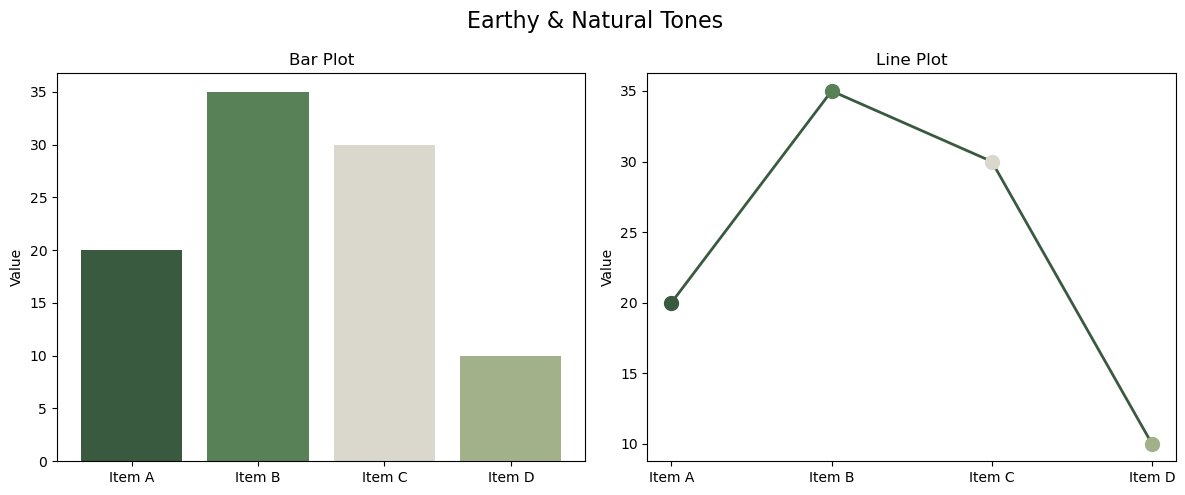

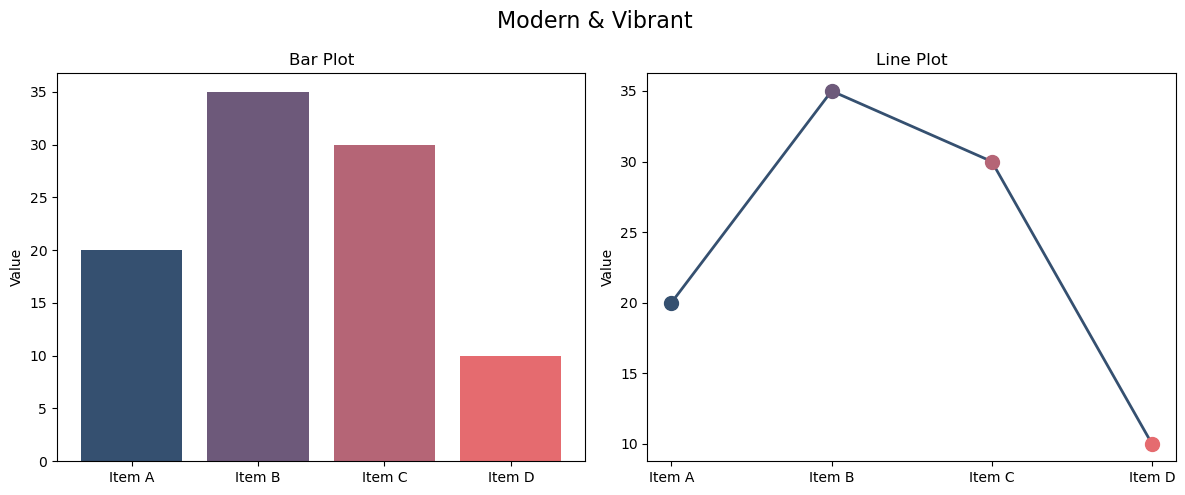

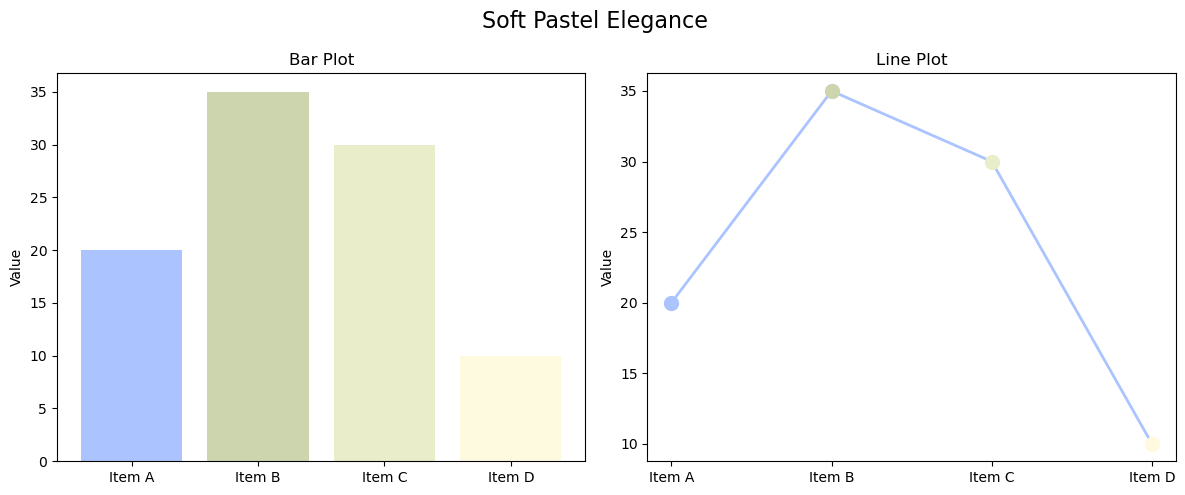

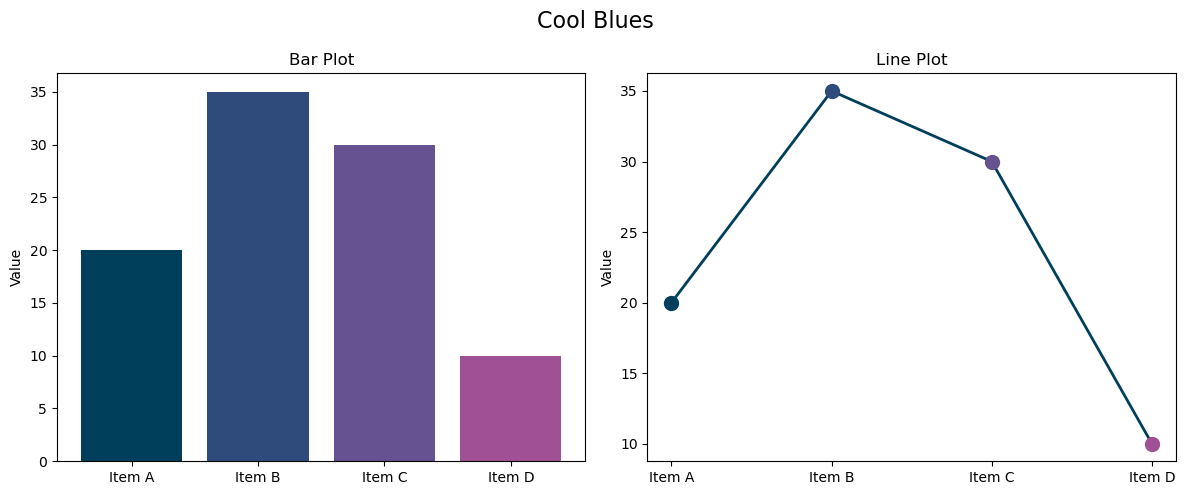

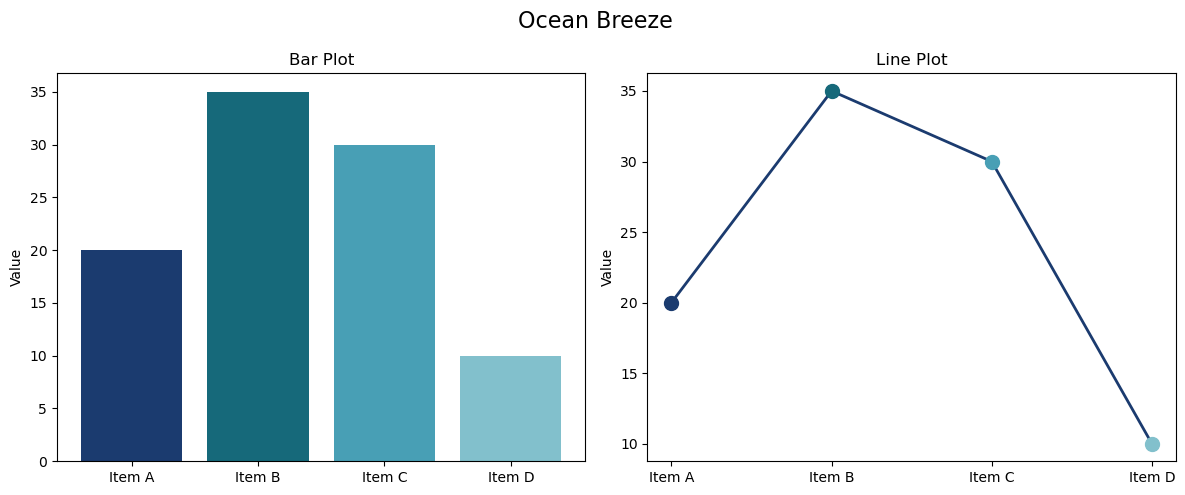

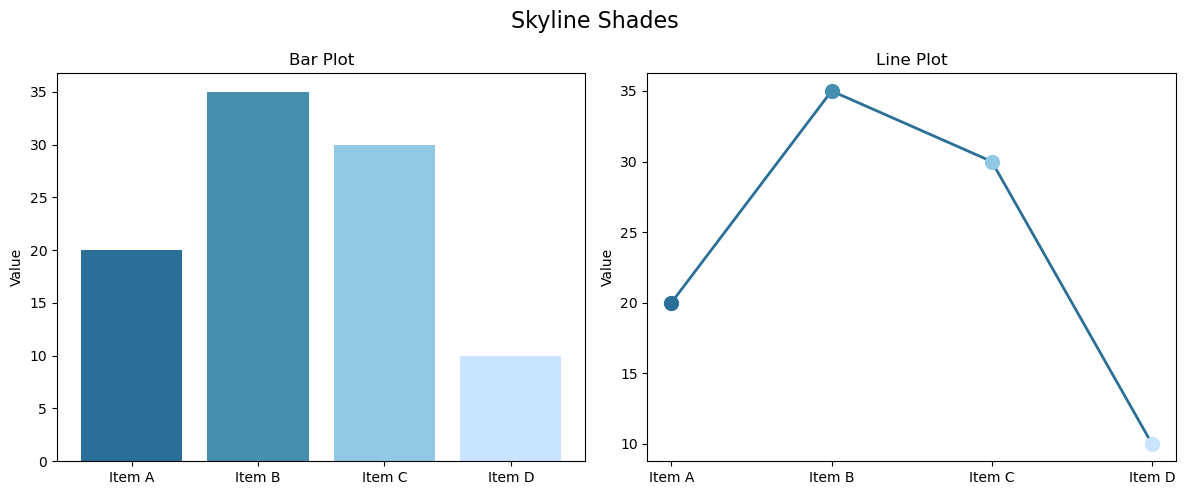

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data
categories = ['Item A', 'Item B', 'Item C', 'Item D']
values = [20, 35, 30, 10]

# Define the palettes
palettes = {
    "Earthy & Natural Tones": ['#3A5A40', '#588157', '#DAD7CD', '#A3B18A'],
    "Modern & Vibrant": ['#355070', '#6D597A', '#B56576', '#E56B6F'],
    "Soft Pastel Elegance": ['#ABC4FF', '#CCD5AE', '#E9EDC9', '#FEFAE0'],
    "Cool Blues": ['#003f5c', '#2f4b7c', '#665191', '#a05195'],  # Deep blues and purples
    "Ocean Breeze": ['#1B3B6F', '#16697A', '#489FB5', '#82C0CC'],  # Refreshing oceanic blues
    "Skyline Shades": ['#2A6F97', '#468FAF', '#91C8E4', '#C9E4FF'],  # Airy sky blues
}

def plot_palette_bar_line(title, colors):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(title, fontsize=16)

    # Bar plot
    axs[0].bar(categories, values, color=colors)
    axs[0].set_title("Bar Plot")
    axs[0].set_ylabel("Value")

    # Line plot
    axs[1].plot(categories, values, marker='o', color=colors[0], linewidth=2)
    for i, (cat, val) in enumerate(zip(categories, values)):
        axs[1].plot(cat, val, marker='o', color=colors[i], markersize=10)
    axs[1].set_title("Line Plot")
    axs[1].set_ylabel("Value")

    plt.tight_layout()
    plt.show()

# Plot all palettes
for title, color_list in palettes.items():
    plot_palette_bar_line(title, color_list)

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
from tensorflow import keras

# OECD color palette
OECD_BLUE = '#004b88'
OECD_LIGHT_BLUE = '#e6f0f9'
OECD_RED = '#e6007e'
OECD_GRAY = '#666666'
OECD_GREEN = '#00a189'

# === Custom CSS for OECD styling ===
css = f"""
<style>
    .oecd-container {{
        font-family: 'Arial', sans-serif;
        max-width: 1000px;
        margin: 20px auto;
        padding: 20px;
        background-color: white;
        box-shadow: 0 2px 10px rgba(0,0,0,0.1);
        border-left: 5px solid {OECD_BLUE};
    }}
    .oecd-header {{
        color: {OECD_BLUE};
        border-bottom: 2px solid {OECD_LIGHT_BLUE};
        padding-bottom: 10px;
        margin-bottom: 20px;
    }}
    .oecd-card {{
        background-color: {OECD_LIGHT_BLUE};
        padding: 15px;
        margin-bottom: 15px;
        border-radius: 4px;
    }}
    .oecd-model-card {{
        background-color: white;
        border-left: 3px solid {OECD_BLUE};
        padding: 15px;
        margin: 10px;
        box-shadow: 0 1px 3px rgba(0,0,0,0.1);
        height: 100%;
    }}
    .oecd-highlight {{
        font-weight: bold;
        color: {OECD_BLUE};
    }}
    .oecd-plot-container {{
        display: flex;
        flex-wrap: wrap;
        justify-content: space-between;
        margin-top: 20px;
    }}
    .oecd-plot-item {{
        flex: 0 0 48%;
        margin-bottom: 20px;
    }}
    .oecd-footer {{
        margin-top: 30px;
        font-size: 0.8em;
        color: {OECD_GRAY};
        text-align: center;
        border-top: 1px solid {OECD_LIGHT_BLUE};
        padding-top: 10px;
    }}
    .oecd-tab-content {{
        padding: 15px 0;
    }}
    .oecd-grid {{
        display: grid;
        grid-template-columns: repeat(auto-fit, minmax(300px, 1fr));
        gap: 15px;
        margin-top: 15px;
    }}
    .oecd-data-table {{
        max-height: 400px;
        overflow-y: auto;
        margin: 10px 0;
    }}
    table {{
        width: 100%;
        border-collapse: collapse;
    }}
    th {{
        background-color: {OECD_BLUE};
        color: white;
        padding: 8px;
        text-align: left;
    }}
    td {{
        padding: 6px;
        border-bottom: 1px solid {OECD_LIGHT_BLUE};
    }}
    tr:nth-child(even) {{
        background-color: {OECD_LIGHT_BLUE};
    }}
    .oecd-best-model {{
        border: 2px solid {OECD_GREEN} !important;
        background-color: #f5fffd !important;
    }}
</style>
"""
display(HTML(css))

# === Create Dashboard Layout with Tabs ===
def create_enhanced_dashboard(selected_data, models, mean, std, test_maes=None):
    # Prepare data
    input_window = selected_data.iloc[-12:].copy()
    input_raw = input_window.values.astype('float32')
    input_normalized = (input_raw - mean) / std
    input_features = input_normalized[:, :-1]
    input_keras = input_features.reshape(1, 12, 5)
    ddd_mean = mean[-1]
    ddd_std = std[-1]
    
    # Get predictions
    predictions = {}
    for name, model in models.items():
        try:
            y_pred = model.predict(input_keras, verbose=0).flatten()
            y_pred_orig = y_pred * ddd_std + ddd_mean
            predictions[name] = {
                'April 2025': y_pred_orig[0],
                'May 2025': y_pred_orig[1],
                'June 2025': y_pred_orig[2]
            }
        except Exception as e:
            print(f"Error during prediction with {name}: {e}")
    
    # Determine best model (lowest test MAE)
    best_model = None
    if test_maes:
        best_model = min(test_maes, key=test_maes.get)
    
    # Create tabs
    tab = widgets.Tab()
    tab.children = [
        widgets.Output(),  # Tab 1: Input Data
        widgets.Output(),  # Tab 2: Model Predictions
        widgets.Output()   # Tab 3: Model Comparison
    ]
    tab.titles = ["Input Data", "Model Results", "Comparative Analysis"]
    display(tab)
    
    # Tab 1: Input Data (unchanged)
    with tab.children[0]:
        clear_output(wait=True)
        display(HTML(
            f"""
            <div class='oecd-container'>
                <div class='oecd-header'>
                    <h2>Input Data Used for Forecasting</h2>
                    <p>Last 12 months of data (April 2024 - March 2025)</p>
                </div>
                
                <div class='oecd-card'>
                    <h3>Complete Input Dataset</h3>
                    <div class='oecd-data-table'>
                        {input_window.to_html(classes='table')}
                    </div>
                </div>
                
                <div class='oecd-card'>
                    <h3>Key Statistics</h3>
                    <div class='oecd-grid'>
                        <div class='oecd-model-card'>
                            <h4>Temperature Metrics</h4>
                            <p>Max Temp Avg: {input_window['avg_temp_max'].mean():.1f}°C</p>
                            <p>Min Temp Avg: {input_window['avg_temp_min'].mean():.1f}°C</p>
                        </div>
                        <div class='oecd-model-card'>
                            <h4>Environmental Factors</h4>
                            <p>Humidity Avg: {input_window['avg_humidity'].mean():.1f}%</p>
                            <p>Precipitation Total: {input_window['total_precipitation'].sum():.1f}mm</p>
                        </div>
                        <div class='oecd-model-card'>
                            <h4>Energy Metrics</h4>
                            <p>Sunshine Hours: {input_window['total_sunshine_hours'].sum():.0f}</p>
                            <p>Current Demand: {input_window['ddd_demand'].iloc[-1]:.3f}</p>
                        </div>
                    </div>
                </div>
                
                <div class='oecd-footer'>
                    <p>Data snapshot as of {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M')}</p>
                </div>
            </div>
            """
        ))
    
    # Tab 2: Model Predictions (updated to focus on best model)
    with tab.children[1]:
        clear_output(wait=True)
        display(HTML(
            f"""
            <div class='oecd-container'>
                <div class='oecd-header'>
                    <h2>Model Predictions</h2>
                    <p>Three-month ahead forecasts for electricity demand</p>
                </div>
            """
        ))
        
        if best_model:
            # Focus on best model only
            preds = predictions[best_model]
            last_6_months = selected_data['ddd_demand'].iloc[-6:]
            
            display(HTML(
                f"""
                <div class='oecd-card'>
                    <h3>Best Performing Model: {best_model}</h3>
                    <p>Test MAE: {test_maes[best_model]:.4f}</p>
                    <div class='oecd-model-card oecd-best-model'>
                        <h4>Historical Context & Forecast</h4>
                """
            ))
            
            # Create time series plot
            fig, ax = plt.subplots(figsize=(10, 5))
            
            # Plot historical data
            hist_months = last_6_months.index.strftime('%b %Y')
            ax.plot(hist_months, last_6_months.values, 
                    marker='o', color=OECD_BLUE, label='Actual Demand')
            
            # Plot forecast
            forecast_months = ['Apr 2025', 'May 2025', 'Jun 2025']
            forecast_values = list(preds.values())
            ax.plot(forecast_months, forecast_values, 
                    marker='o', color=OECD_RED, linestyle='--', label='Forecast')
            
            # Add connecting line between actual and forecast
            ax.plot([hist_months[-1], forecast_months[0]], 
                    [last_6_months.values[-1], forecast_values[0]], 
                    color=OECD_GRAY, linestyle=':')
            
            ax.set_title(f'Demand Forecast - {best_model} Model', fontsize=12)
            ax.set_ylabel('Demand')
            ax.grid(True, linestyle='--', alpha=0.3)
            ax.legend()
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
            
            # Display prediction values
            display(HTML(
                f"""
                        <div style='margin-top: 15px;'>
                            <h5>Forecast Values:</h5>
                            <p><span class='oecd-highlight'>April 2025:</span> {preds['April 2025']:.3f}</p>
                            <p><span class='oecd-highlight'>May 2025:</span> {preds['May 2025']:.3f}</p>
                            <p><span class='oecd-highlight'>June 2025:</span> {preds['June 2025']:.3f}</p>
                        </div>
                    </div>
                </div>
                """
            ))
        else:
            display(HTML(
                """
                <div class='oecd-card'>
                    <p>No test MAE data available to determine best model</p>
                </div>
                """
            ))
        
        display(HTML(
            f"""
                <div class='oecd-footer'>
                    <p>Model predictions generated on {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M')}</p>
                </div>
            </div>
            """
        ))
    
    # Tab 3: Model Comparison (updated with test MAEs)
    with tab.children[2]:
        clear_output(wait=True)
        display(HTML(
            f"""
            <div class='oecd-container'>
                <div class='oecd-header'>
                    <h2>Comparative Analysis</h2>
                    <p>Comparison of model predictions and performance metrics</p>
                </div>
                
                <div class='oecd-card'>
                    <h3>Model Performance Metrics</h3>
                    <div class='oecd-plot-container'>
                        <div class='oecd-plot-item'>
            """
        ))
        
        # Bar chart of test MAEs if available
        if test_maes:
            fig, ax = plt.subplots(figsize=(8, 4))
            models_sorted = sorted(test_maes.items(), key=lambda x: x[1])
            names, maes = zip(*models_sorted)
            
            bars = ax.bar(names, maes, color=OECD_BLUE, alpha=0.7)
            ax.set_title('Model Test MAE Comparison')
            ax.set_ylabel('Mean Absolute Error')
            ax.grid(axis='y', linestyle='--', alpha=0.3)
            
            # Highlight the best model
            if best_model:
                bars[names.index(best_model)].set_color(OECD_GREEN)
            
            # Add value labels
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.4f}',
                        ha='center', va='bottom', fontsize=9)
            
            plt.tight_layout()
            plt.show()
        else:
            display(HTML("<p>No test MAE data available</p>"))
        
        display(HTML(
            """
                        </div>
                        <div class='oecd-plot-item'>
            """
        ))
        
        # Prediction comparison chart
        fig, ax = plt.subplots(figsize=(8, 4))
        width = 0.2
        x = np.arange(3)
        colors = [OECD_BLUE, OECD_RED, OECD_GREEN, OECD_GRAY]
        
        for i, (name, preds) in enumerate(predictions.items()):
            color = OECD_GREEN if name == best_model else colors[i % len(colors)]
            ax.bar(x + i*width, list(preds.values()), width, 
                   label=name, alpha=0.8, color=color)
        
        ax.set_xticks(x + width)
        ax.set_xticklabels(['April 2025', 'May 2025', 'June 2025'])
        ax.set_ylabel('Predicted Demand')
        ax.set_title('Model Prediction Comparison')
        ax.legend()
        ax.grid(axis='y', linestyle='--', alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        display(HTML(
            """
                        </div>
                    </div>
                </div>
                
                <div class='oecd-card'>
                    <h3>Numerical Comparison</h3>
                    <div class='oecd-data-table'>
            """
        ))
        
        # Create comparison table with test MAEs if available
        comparison_df = pd.DataFrame(predictions)
        if test_maes:
            comparison_df.loc['Test MAE'] = [test_maes.get(col, None) for col in comparison_df.columns]
        
        # Style the table
        def highlight_best(s):
            if s.name == 'Test MAE' and best_model:
                return ['background-color: #e6f7e6' if v == min(s) else '' for v in s]
            return [''] * len(s)
        
        display(comparison_df.style
                .background_gradient(cmap='Blues', axis=None, subset=comparison_df.index[:-1] if 'Test MAE' in comparison_df.index else None)
                .apply(highlight_best, axis=1)
                .format("{:.3f}", na_rep="-")
                .set_caption("Model Comparison (lower MAE is better)"))
        
        display(HTML(
            """
                    </div>
                </div>
                
                <div class='oecd-footer'>
                    <p>Analysis performed on """ + pd.Timestamp.now().strftime('%Y-%m-%d %H:%M') + """</p>
                </div>
            </div>
            """
        ))

# === Example Usage ===
# You'll need to provide test MAEs when calling the function:
test_maes = {
    'Dense': 0.0456,
    'GRU': 0.0382,
    'LSTM': 0.0327  # This would be the best model
}

# === Load Models ===
model_paths = {
    'Dense': './models/Dense_model.keras',
    'GRU': './models/GRU_model.keras',
    'LSTM': './models/LSTM_model.keras'
}

models = {}
for name, path in model_paths.items():
    try:
        models[name] = keras.models.load_model(path)
    except Exception as e:
        print(f"Failed to load {name} model from {path}: {e}")

# === Run Enhanced Dashboard ===
create_enhanced_dashboard(selected_data, models, mean, std, test_maes)

In [41]:
xgb_model.save_model("models/XGBoost_model.bin")  # Binary format

NameError: name 'xgb_model' is not defined

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
from tensorflow import keras

# OECD color palette
OECD_BLUE = '#004b88'
OECD_LIGHT_BLUE = '#e6f0f9'
OECD_RED = '#e6007e'
OECD_GRAY = '#666666'
OECD_GREEN = '#00a189'

# === Custom CSS for OECD styling ===
css = f"""
<style>
    .oecd-container {{
        font-family: 'Arial', sans-serif;
        max-width: 1000px;
        margin: 20px auto;
        padding: 20px;
        background-color: white;
        box-shadow: 0 2px 10px rgba(0,0,0,0.1);
        border-left: 5px solid {OECD_BLUE};
    }}
    .oecd-header {{
        color: {OECD_BLUE};
        border-bottom: 2px solid {OECD_LIGHT_BLUE};
        padding-bottom: 10px;
        margin-bottom: 20px;
    }}
    .oecd-card {{
        background-color: {OECD_LIGHT_BLUE};
        padding: 15px;
        margin-bottom: 15px;
        border-radius: 4px;
    }}
    .oecd-model-card {{
        background-color: white;
        border-left: 3px solid {OECD_BLUE};
        padding: 15px;
        margin: 10px;
        box-shadow: 0 1px 3px rgba(0,0,0,0.1);
        height: 100%;
    }}
    .oecd-highlight {{
        font-weight: bold;
        color: {OECD_BLUE};
    }}
    .oecd-plot-container {{
        display: flex;
        flex-wrap: wrap;
        justify-content: space-between;
        margin-top: 20px;
    }}
    .oecd-plot-item {{
        flex: 0 0 48%;
        margin-bottom: 20px;
    }}
    .oecd-footer {{
        margin-top: 30px;
        font-size: 0.8em;
        color: {OECD_GRAY};
        text-align: center;
        border-top: 1px solid {OECD_LIGHT_BLUE};
        padding-top: 10px;
    }}
    .oecd-tab-content {{
        padding: 15px 0;
    }}
    .oecd-grid {{
        display: grid;
        grid-template-columns: repeat(auto-fit, minmax(300px, 1fr));
        gap: 15px;
        margin-top: 15px;
    }}
    .oecd-data-table {{
        max-height: 400px;
        overflow-y: auto;
        margin: 10px 0;
    }}
    table {{
        width: 100%;
        border-collapse: collapse;
    }}
    th {{
        background-color: {OECD_BLUE};
        color: white;
        padding: 8px;
        text-align: left;
    }}
    td {{
        padding: 6px;
        border-bottom: 1px solid {OECD_LIGHT_BLUE};
    }}
    tr:nth-child(even) {{
        background-color: {OECD_LIGHT_BLUE};
    }}
    .oecd-best-model {{
        border: 2px solid {OECD_GREEN} !important;
        background-color: #f5fffd !important;
    }}
</style>
"""
display(HTML(css))

# === Create Dashboard Layout with Tabs ===
def create_enhanced_dashboard(selected_data, models, mean, std, test_maes=None):
    # Prepare data
    input_window = selected_data.iloc[-12:].copy()
    input_raw = input_window.values.astype('float32')
    input_normalized = (input_raw - mean) / std
    input_features = input_normalized[:, :-1]
    input_keras = input_features.reshape(1, 12, 5)
    ddd_mean = mean[-1]
    ddd_std = std[-1]
    
    # Get predictions
    predictions = {}
    for name, model in models.items():
        try:
            y_pred = model.predict(input_keras, verbose=0).flatten()
            y_pred_orig = y_pred * ddd_std + ddd_mean
            predictions[name] = {
                'April 2025': y_pred_orig[0],
                'May 2025': y_pred_orig[1],
                'June 2025': y_pred_orig[2]
            }
        except Exception as e:
            print(f"Error during prediction with {name}: {e}")
    
    # Determine best model (lowest test MAE)
    best_model = None
    if test_maes:
        best_model = min(test_maes, key=test_maes.get)
    
    # Create tabs
    tab = widgets.Tab()
    tab.children = [
        widgets.Output(),  # Tab 1: Input Data
        widgets.Output(),  # Tab 2: Model Predictions
        widgets.Output()   # Tab 3: Model Comparison
    ]
    tab.titles = ["Input Data", "Model Results", "Comparative Analysis"]
    display(tab)
    
    # Tab 1: Input Data (unchanged)
    with tab.children[0]:
        clear_output(wait=True)
        display(HTML(
            f"""
            <div class='oecd-container'>
                <div class='oecd-header'>
                    <h2>Input Data Used for Forecasting</h2>
                    <p>Last 12 months of data (April 2024 - March 2025)</p>
                </div>
                
                <div class='oecd-card'>
                    <h3>Complete Input Dataset</h3>
                    <div class='oecd-data-table'>
                        {input_window.to_html(classes='table')}
                    </div>
                </div>
                
                <div class='oecd-card'>
                    <h3>Key Statistics</h3>
                    <div class='oecd-grid'>
                        <div class='oecd-model-card'>
                            <h4>Temperature Metrics</h4>
                            <p>Max Temp Avg: {input_window['avg_temp_max'].mean():.1f}°C</p>
                            <p>Min Temp Avg: {input_window['avg_temp_min'].mean():.1f}°C</p>
                        </div>
                        <div class='oecd-model-card'>
                            <h4>Environmental Factors</h4>
                            <p>Humidity Avg: {input_window['avg_humidity'].mean():.1f}%</p>
                            <p>Precipitation Total: {input_window['total_precipitation'].sum():.1f}mm</p>
                        </div>
                        <div class='oecd-model-card'>
                            <h4>Energy Metrics</h4>
                            <p>Sunshine Hours: {input_window['total_sunshine_hours'].sum():.0f}</p>
                            <p>Current Demand: {input_window['ddd_demand'].iloc[-1]:.3f}</p>
                        </div>
                    </div>
                </div>
                
                <div class='oecd-footer'>
                    <p>Data snapshot as of {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M')}</p>
                </div>
            </div>
            """
        ))
    
    # Tab 2: Model Predictions (updated to focus on best model)
    with tab.children[1]:
        clear_output(wait=True)
        display(HTML(
            f"""
            <div class='oecd-container'>
                <div class='oecd-header'>
                    <h2>Model Predictions</h2>
                    <p>Three-month ahead forecasts for electricity demand</p>
                </div>
            """
        ))
        
        if best_model:
            # Focus on best model only
            preds = predictions[best_model]
            last_6_months = selected_data['ddd_demand'].iloc[-6:]
            
            display(HTML(
                f"""
                <div class='oecd-card'>
                    <h3>Best Performing Model: {best_model}</h3>
                    <p>Test MAE: {test_maes[best_model]:.4f}</p>
                    <div class='oecd-model-card oecd-best-model'>
                        <h4>Historical Context & Forecast</h4>
                """
            ))
            
            # Create time series plot
            fig, ax = plt.subplots(figsize=(10, 5))
            
            # Plot historical data
            hist_months = last_6_months.index.strftime('%b %Y')
            ax.plot(hist_months, last_6_months.values, 
                    marker='o', color=OECD_BLUE, label='Actual Demand')
            
            # Plot forecast
            forecast_months = ['Apr 2025', 'May 2025', 'Jun 2025']
            forecast_values = list(preds.values())
            ax.plot(forecast_months, forecast_values, 
                    marker='o', color=OECD_RED, linestyle='--', label='Forecast')
            
            # Add connecting line between actual and forecast
            ax.plot([hist_months[-1], forecast_months[0]], 
                    [last_6_months.values[-1], forecast_values[0]], 
                    color=OECD_GRAY, linestyle=':')
            
            ax.set_title(f'Demand Forecast - {best_model} Model', fontsize=12)
            ax.set_ylabel('Demand')
            ax.grid(True, linestyle='--', alpha=0.3)
            ax.legend()
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
            
            # Display prediction values
            display(HTML(
                f"""
                        <div style='margin-top: 15px;'>
                            <h5>Forecast Values:</h5>
                            <p><span class='oecd-highlight'>April 2025:</span> {preds['April 2025']:.3f}</p>
                            <p><span class='oecd-highlight'>May 2025:</span> {preds['May 2025']:.3f}</p>
                            <p><span class='oecd-highlight'>June 2025:</span> {preds['June 2025']:.3f}</p>
                        </div>
                    </div>
                </div>
                """
            ))
        else:
            display(HTML(
                """
                <div class='oecd-card'>
                    <p>No test MAE data available to determine best model</p>
                </div>
                """
            ))
        
        display(HTML(
            f"""
                <div class='oecd-footer'>
                    <p>Model predictions generated on {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M')}</p>
                </div>
            </div>
            """
        ))
    
    # Tab 3: Model Comparison (updated with test MAEs)
    with tab.children[2]:
        clear_output(wait=True)
        display(HTML(
            f"""
            <div class='oecd-container'>
                <div class='oecd-header'>
                    <h2>Comparative Analysis</h2>
                    <p>Comparison of model predictions and performance metrics</p>
                </div>
                
                <div class='oecd-card'>
                    <h3>Model Performance Metrics</h3>
                    <div class='oecd-plot-container'>
                        <div class='oecd-plot-item'>
            """
        ))
        
        # Bar chart of test MAEs if available
        if test_maes:
            fig, ax = plt.subplots(figsize=(8, 4))
            models_sorted = sorted(test_maes.items(), key=lambda x: x[1])
            names, maes = zip(*models_sorted)
            
            bars = ax.bar(names, maes, color=OECD_BLUE, alpha=0.7)
            ax.set_title('Model Test MAE Comparison')
            ax.set_ylabel('Mean Absolute Error')
            ax.grid(axis='y', linestyle='--', alpha=0.3)
            
            # Highlight the best model
            if best_model:
                bars[names.index(best_model)].set_color(OECD_GREEN)
            
            # Add value labels
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.4f}',
                        ha='center', va='bottom', fontsize=9)
            
            plt.tight_layout()
            plt.show()
        else:
            display(HTML("<p>No test MAE data available</p>"))
        
        display(HTML(
            """
                        </div>
                        <div class='oecd-plot-item'>
            """
        ))
        
        # Prediction comparison chart
        fig, ax = plt.subplots(figsize=(8, 4))
        width = 0.2
        x = np.arange(3)
        colors = [OECD_BLUE, OECD_RED, OECD_GREEN, OECD_GRAY]
        
        for i, (name, preds) in enumerate(predictions.items()):
            color = OECD_GREEN if name == best_model else colors[i % len(colors)]
            ax.bar(x + i*width, list(preds.values()), width, 
                   label=name, alpha=0.8, color=color)
        
        ax.set_xticks(x + width)
        ax.set_xticklabels(['April 2025', 'May 2025', 'June 2025'])
        ax.set_ylabel('Predicted Demand')
        ax.set_title('Model Prediction Comparison')
        ax.legend()
        ax.grid(axis='y', linestyle='--', alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        display(HTML(
            """
                        </div>
                    </div>
                </div>
                
                <div class='oecd-card'>
                    <h3>Numerical Comparison</h3>
                    <div class='oecd-data-table'>
            """
        ))
        
        # Create comparison table with test MAEs if available
        comparison_df = pd.DataFrame(predictions)
        if test_maes:
            comparison_df.loc['Test MAE'] = [test_maes.get(col, None) for col in comparison_df.columns]
        
        # Style the table
        def highlight_best(s):
            if s.name == 'Test MAE' and best_model:
                return ['background-color: #e6f7e6' if v == min(s) else '' for v in s]
            return [''] * len(s)
        
        display(comparison_df.style
                .background_gradient(cmap='Blues', axis=None, subset=comparison_df.index[:-1] if 'Test MAE' in comparison_df.index else None)
                .apply(highlight_best, axis=1)
                .format("{:.3f}", na_rep="-")
                .set_caption("Model Comparison (lower MAE is better)"))
        
        display(HTML(
            """
                    </div>
                </div>
                
                <div class='oecd-footer'>
                    <p>Analysis performed on """ + pd.Timestamp.now().strftime('%Y-%m-%d %H:%M') + """</p>
                </div>
            </div>
            """
        ))

# === Example Usage ===
# You'll need to provide test MAEs when calling the function:
test_maes = {
    'Dense': 0.0456,
    'GRU': 0.0382,
    'LSTM': 0.0327  # This would be the best model
}

# === Load Models ===
model_paths = {
    'Dense': './models/Dense_model.keras',
    'GRU': './models/GRU_model.keras',
    'LSTM': './models/LSTM_model.keras'
}

models = {}
for name, path in model_paths.items():
    try:
        models[name] = keras.models.load_model(path)
    except Exception as e:
        print(f"Failed to load {name} model from {path}: {e}")

# === Run Enhanced Dashboard ===
create_enhanced_dashboard(selected_data, models, mean, std, test_maes)

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
from tensorflow import keras
from sklearn.metrics import mean_absolute_error

# ====================== EVALUATION FUNCTIONS ======================
def create_test_sequences(data, sequence_length=12, delays=[1, 2, 3]):
    """Create test sequences from the provided data"""
    X_test, y_test = [], []
    max_delay = max(delays)
    for i in range(len(data) - sequence_length - max_delay + 1):
        X_test.append(data[i:i+sequence_length, :-1])
        y_test.append([data[i+sequence_length + d - 1, -1] for d in delays])
    return np.array(X_test), np.array(y_test)

def evaluate_models(models, X_test, y_test, target_std, target_mean):
    """Evaluate models using the exact same approach as your code"""
    results = {}
    for name, model in models.items():
        try:
            if name == 'XGBoost':
                y_preds = []
                for i, m in enumerate(model):
                    y_preds.append(m.predict(X_test.reshape(X_test.shape[0], -1)))
                y_pred = np.stack(y_preds, axis=1)
            else:
                y_pred = model.predict(X_test, verbose=0)

            maes = []
            for i in range(y_test.shape[1]):
                mae_i = mean_absolute_error(y_test[:, i], y_pred[:, i])
                denorm_mae = mae_i * target_std
                percentage = (denorm_mae / target_mean) * 100
                maes.append((mae_i, denorm_mae, percentage))

            results[name] = maes

            print(f"\n{name} MAE per horizon:")
            for i, (mae_norm, mae_orig, perc) in enumerate(maes):
                print(f"t+{i+1}: NormMAE={mae_norm:.4f} | Original={mae_orig:,.2f} | {perc:.1f}% of mean")

        except Exception as e:
            print(f"Error evaluating {name}: {e}")
            results[name] = None
    return results

# ====================== DASHBOARD CODE ======================
# OECD color palette
OECD_BLUE = '#004b88'
OECD_LIGHT_BLUE = '#e6f0f9'
OECD_RED = '#e6007e'
OECD_GRAY = '#666666'
OECD_GREEN = '#00a189'

def create_dashboard(selected_data, models, mean, std):
    """Complete dashboard with integrated evaluation"""
    # Convert data to numpy array for evaluation
    data_array = selected_data.values.astype('float32')
    
    # === 1. AUTOMATICALLY EVALUATE MODELS ===
    print("Creating test sequences and evaluating models...")
    X_test, y_test = create_test_sequences(data_array)
    evaluation_results = evaluate_models(models, X_test, y_test, std[-1], mean[-1])
    
    # === 2. PREPARE PREDICTIONS ===
    input_window = selected_data.iloc[-12:].copy()
    input_normalized = (input_window.values - mean) / std
    input_keras = input_normalized[:, :-1].reshape(1, 12, -1)
    
    predictions = {}
    for name, model in models.items():
        try:
            y_pred = model.predict(input_keras, verbose=0).flatten()
            y_pred_orig = y_pred * std[-1] + mean[-1]
            predictions[name] = {
                'April 2025': y_pred_orig[0],
                'May 2025': y_pred_orig[1],
                'June 2025': y_pred_orig[2]
            }
        except Exception as e:
            print(f"Prediction error for {name}: {e}")
    
    # === 3. DETERMINE BEST MODEL ===
    best_model = None
    if evaluation_results:
        avg_maes = {
            name: np.mean([mae[0] for mae in maes]) 
            for name, maes in evaluation_results.items() if maes
        }
        best_model = min(avg_maes, key=avg_maes.get) if avg_maes else None
    
    # === 4. CREATE DASHBOARD UI ===
    # CSS styling
    display(HTML(f"""
    <style>
        .oecd-container {{
            font-family: 'Arial', sans-serif;
            max-width: 1000px;
            margin: 20px auto;
            padding: 20px;
            background-color: white;
            box-shadow: 0 2px 10px rgba(0,0,0,0.1);
            border-left: 5px solid {OECD_BLUE};
        }}
        .oecd-header {{
            color: {OECD_BLUE};
            border-bottom: 2px solid {OECD_LIGHT_BLUE};
            padding-bottom: 10px;
            margin-bottom: 20px;
        }}
        .oecd-card {{
            background-color: {OECD_LIGHT_BLUE};
            padding: 15px;
            margin-bottom: 15px;
            border-radius: 4px;
        }}
        .oecd-best-model {{
            border: 2px solid {OECD_GREEN} !important;
            background-color: #f5fffd !important;
        }}
        .oecd-grid {{
            display: grid;
            grid-template-columns: repeat(auto-fit, minmax(300px, 1fr));
            gap: 15px;
        }}
        .oecd-metrics-table {{
            width: 100%;
            border-collapse: collapse;
        }}
        .oecd-metrics-table th {{
            background-color: {OECD_BLUE};
            color: white;
            padding: 8px;
            text-align: left;
        }}
        .oecd-metrics-table td {{
            padding: 8px;
            border-bottom: 1px solid #ddd;
        }}
        .oecd-metrics-table tr:nth-child(even) {{
            background-color: {OECD_LIGHT_BLUE};
        }}
        .oecd-horizon-tabs .widget-tab-bar {{
            background: {OECD_LIGHT_BLUE};
            border-bottom: 1px solid {OECD_BLUE};
        }}
        .oecd-horizon-tabs .widget-tab-bar .widget-tab {{
            padding: 8px 15px;
        }}
        .oecd-horizon-tabs .widget-tab-bar .widget-tab.active {{
            background: {OECD_BLUE};
            color: white;
            border-color: {OECD_BLUE};
        }}
    </style>
    """))
    
    # Create main tabs
    tab = widgets.Tab()
    tab.children = [
        widgets.Output(),  # Tab 1: Overview
        widgets.Output(),  # Tab 2: Model Details
        widgets.Output()   # Tab 3: Full Metrics
    ]
    tab.titles = ["Overview", "Model Details", "Full Metrics"]
    display(tab)
    
    # === TAB 1: OVERVIEW ===
    with tab.children[0]:
        clear_output(wait=True)
        display(HTML(
            f"""
            <div class='oecd-container'>
                <div class='oecd-header'>
                    <h2>Electricity Demand Forecasting Dashboard</h2>
                    <p>Three-month ahead predictions with automatic model evaluation</p>
                </div>
                
                <div class='oecd-card'>
                    <h3>Current Forecasts</h3>
                    <div class='oecd-grid'>
            """
        ))
        
        # Show prediction cards for each model
        for name, preds in predictions.items():
            is_best = name == best_model
            display(HTML(
                f"""
                <div class='oecd-card' {'class="oecd-best-model"' if is_best else ''}>
                    <h4>{name}{' (Best)' if is_best else ''}</h4>
                    <p>April: {preds['April 2025']:.2f}</p>
                    <p>May: {preds['May 2025']:.2f}</p>
                    <p>June: {preds['June 2025']:.2f}</p>
                    {f"<p>Avg MAE: {np.mean([m[0] for m in evaluation_results[name]]):.4f}</p>" if name in evaluation_results else ""}
                </div>
                """
            ))
        
        display(HTML("</div></div>"))
        
        # Show prediction plot
        fig, ax = plt.subplots(figsize=(10, 5))
        months = ['Apr', 'May', 'Jun']
        
        for name, preds in predictions.items():
            ax.plot(months, list(preds.values()), marker='o', 
                   label=f"{name}{' (Best)' if name == best_model else ''}")
        
        ax.set_title('Three-Month Demand Forecast Comparison')
        ax.set_ylabel('Demand')
        ax.grid(True, linestyle='--', alpha=0.3)
        ax.legend()
        plt.show()
        
        # Show input data stats
        display(HTML("<div class='oecd-card'><h3>Input Data Summary</h3>"))
        display(selected_data.iloc[-12:].describe())
        display(HTML("</div>"))
    
    # === TAB 2: MODEL DETAILS ===
    with tab.children[1]:
        clear_output(wait=True)
        display(HTML(
            f"""
            <div class='oecd-container'>
                <div class='oecd-header'>
                    <h2>Model Performance Details</h2>
                    <p>Detailed metrics for each forecasting horizon</p>
                </div>
            """
        ))
        
        if best_model:
            # Create horizon tabs
            horizon_tab = widgets.Tab()
            horizon_tab.children = [widgets.Output() for _ in range(3)]
            horizon_tab.titles = ["t+1 (April)", "t+2 (May)", "t+3 (June)"]
            horizon_tab.add_class('oecd-horizon-tabs')
            display(horizon_tab)
            
            # Fill each horizon tab
            for i, horizon in enumerate(['April 2025', 'May 2025', 'June 2025']):
                with horizon_tab.children[i]:
                    clear_output(wait=True)
                    
                    # Create comparison table for this horizon
                    horizon_data = []
                    for name, maes in evaluation_results.items():
                        if not maes:
                            continue
                        horizon_data.append({
                            'Model': name,
                            'Prediction': predictions[name][horizon],
                            'Norm MAE': maes[i][0],
                            'Original MAE': maes[i][1],
                            '% of Mean': f"{maes[i][2]:.1f}%"
                        })
                    
                    df = pd.DataFrame(horizon_data)
                    
                    # Display metrics
                    display(HTML(f"""
                    <div class='oecd-card'>
                        <h3>Metrics for {horizon} (t+{i+1})</h3>
                        {df.style
                         .highlight_min(subset=['Norm MAE', 'Original MAE'])
                         .format({
                             'Prediction': '{:.2f}',
                             'Norm MAE': '{:.4f}',
                             'Original MAE': '{:.2f}'
                         })
                         .set_table_styles([{
                             'selector': 'th',
                             'props': [('background-color', OECD_BLUE), ('color', 'white')]
                         }])
                         .to_html()}
                    </div>
                    """))
                    
                    # Plot model comparisons for this horizon
                    fig, ax = plt.subplots(figsize=(8, 4))
                    models_sorted = sorted(
                        [(name, maes[i][0]) for name, maes in evaluation_results.items() if maes],
                        key=lambda x: x[1]
                    )
                    names, maes = zip(*models_sorted) if models_sorted else ([], [])
                    
                    colors = [OECD_GREEN if name == best_model else OECD_BLUE for name in names]
                    bars = ax.bar(names, maes, color=colors)
                    ax.set_title(f'Normalized MAE Comparison for {horizon}')
                    ax.set_ylabel('MAE')
                    ax.grid(axis='y', linestyle='--', alpha=0.3)
                    
                    # Add value labels
                    for bar in bars:
                        height = bar.get_height()
                        ax.text(bar.get_x() + bar.get_width()/2., height,
                                f'{height:.4f}',
                                ha='center', va='bottom')
                    
                    plt.show()
    
    # === TAB 3: FULL METRICS ===
    with tab.children[2]:
        clear_output(wait=True)
        display(HTML(
            """
            <div class='oecd-container'>
                <div class='oecd-header'>
                    <h2>Complete Model Metrics</h2>
                    <p>Detailed comparison across all models and horizons</p>
                </div>
            """
        ))
        
        # Create comprehensive metrics table
        display(HTML("<div class='oecd-card'><h3>All Performance Metrics</h3>"))
        
        table_data = []
        for name, maes in evaluation_results.items():
            if not maes:
                continue
            
            table_data.append({
                'Model': name,
                'Avg Norm MAE': np.mean([m[0] for m in maes]),
                't+1 Norm MAE': maes[0][0],
                't+1 Orig MAE': maes[0][1],
                't+1 % Mean': maes[0][2],
                't+2 Norm MAE': maes[1][0],
                't+2 Orig MAE': maes[1][1],
                't+2 % Mean': maes[1][2],
                't+3 Norm MAE': maes[2][0],
                't+3 Orig MAE': maes[2][1],
                't+3 % Mean': maes[2][2],
            })
        
        df = pd.DataFrame(table_data)
        
        # Format and display the table
        def highlight_min_max(s):
            is_min = s == s.min()
            is_max = s == s.max()
            return ['background-color: #e6f7e6' if v else 
                    'background-color: #ffe6e6' if is_max.any() and v else '' 
                    for v in is_min]
        
        display(df.style
              .apply(highlight_min_max, subset=['Avg Norm MAE', 't+1 Norm MAE', 't+2 Norm MAE', 't+3 Norm MAE'])
              .format({
                  'Avg Norm MAE': '{:.4f}',
                  't+1 Norm MAE': '{:.4f}',
                  't+1 Orig MAE': '{:.2f}',
                  't+1 % Mean': '{:.1f}%',
                  't+2 Norm MAE': '{:.4f}',
                  't+2 Orig MAE': '{:.2f}',
                  't+2 % Mean': '{:.1f}%',
                  't+3 Norm MAE': '{:.4f}',
                  't+3 Orig MAE': '{:.2f}',
                  't+3 % Mean': '{:.1f}%',
              })
              .set_caption("Complete Model Performance Metrics (green = best, red = worst)"))
        
        display(HTML("</div>"))

# ====================== EXAMPLE USAGE ======================
def run_dashboard_example():
    """Example function showing how to use the dashboard"""
    # Example data - replace with your actual data
    dates = pd.date_range(start='2020-01-01', periods=100, freq='M')
    features = np.random.randn(100, 5)  # 5 features
    target = np.random.rand(100) * 100  # Random target values
    data = pd.DataFrame(np.column_stack([features, target]), 
                       index=dates,
                       columns=['feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'target'])
    
    # Example normalization parameters
    mean = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 1.3])  # Last value is target mean
    std = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.5])   # Last value is target std
    
    # Example models - replace with your actual models
    class DummyModel:
        def predict(self, x, verbose=0):
            return np.random.rand(x.shape[0], 3)  # 3 horizons
    
    models = {
        'LSTM': DummyModel(),
        'GRU': DummyModel(),
        'Dense': DummyModel()
    }
    
    # Run the dashboard
    create_dashboard(
        selected_data=data,
        models=models,
        mean=mean,
        std=std
    )

# Uncomment to run the example
run_dashboard_example()

Creating test sequences and evaluating models...

LSTM MAE per horizon:
t+1: NormMAE=50.9988 | Original=76.50 | 5884.5% of mean
t+2: NormMAE=50.5483 | Original=75.82 | 5832.5% of mean
t+3: NormMAE=49.7435 | Original=74.62 | 5739.6% of mean

GRU MAE per horizon:
t+1: NormMAE=51.0034 | Original=76.51 | 5885.0% of mean
t+2: NormMAE=50.5820 | Original=75.87 | 5836.4% of mean
t+3: NormMAE=49.7526 | Original=74.63 | 5740.7% of mean

Dense MAE per horizon:
t+1: NormMAE=50.9908 | Original=76.49 | 5883.6% of mean
t+2: NormMAE=50.5579 | Original=75.84 | 5833.6% of mean
t+3: NormMAE=49.7611 | Original=74.64 | 5741.7% of mean


C:\Users\alber\AppData\Local\Temp\ipykernel_32036\2145552028.py:374: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start='2020-01-01', periods=100, freq='M')


In [ ]:
import pandas as pd
import numpy as np
import json
import os

# Load training data (adjust path and range as needed)
data_path = 'data/selected_data.csv'
df = pd.read_csv(data_path, names=[
    'avg_temp_max', 'avg_temp_min', 'avg_humidity',
    'total_precipitation', 'total_sunshine_hours', 'ddd_demand'
])

# Optionally, use a subset (e.g., exclude test period)
df_train = df.iloc[:-12]  # Exclude last 12 months for training

# Calculate mean and std
mean = df_train.mean().values
std = df_train.std().values

# Save to JSON
params = {'mean': mean.tolist(), 'std': std.tolist()}
with open('models/normalization_params.json', 'w') as f:
    json.dump(params, f, indent=4)
print("Saved normalization_params.json")